In [2]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

arabic_mnist_path = '/content/drive/MyDrive/Arabic_MNIST'

Mounted at /content/drive


In [ ]:
import pandas as pd

train_images_df = pd.read_csv(f'{arabic_mnist_path}/csvTrainImages 13440x1024.csv')
test_images_df = pd.read_csv(f'{arabic_mnist_path}/csvTestImages 3360x1024.csv')
train_labels_df = pd.read_csv(f'{arabic_mnist_path}/csvTrainLabel 13440x1.csv')
test_labels_df = pd.read_csv(f'{arabic_mnist_path}/csvTestLabel 3360x1.csv')

print("Alle Bild- und Labeldaten wurden erfolgreich geladen.")

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert label DataFrames to NumPy arrays
y_train = train_labels_df.values
y_test = test_labels_df.values

# Determine the number of classes. Labels are 1-indexed, so max_label is num_classes.
num_classes = int(np.max(y_train)) # Assuming labels are 1-indexed

# Apply One-Hot Encoding
y_train_encoded = to_categorical(y_train, num_classes=num_classes + 1)[:, 1:] # Adjust for 0-indexing if necessary
y_test_encoded = to_categorical(y_test, num_classes=num_classes + 1)[:, 1:] # Adjust for 0-indexing if necessary

print(f"Label data successfully converted and One-Hot Encoded into {num_classes} classes.")
print(f"Shape of y_train_encoded: {y_train_encoded.shape}")
print(f"Shape of y_test_encoded: {y_test_encoded.shape}")

Alle Bild- und Labeldaten wurden erfolgreich geladen.
Label data successfully converted and One-Hot Encoded into 28 classes.
Shape of y_train_encoded: (13439, 28)
Shape of y_test_encoded: (3359, 28)


Image data successfully converted, reshaped, and normalized.
Shape of x_train_initial:  (13439, 32, 32, 1)
Shape of x_test_initial:  (3359, 32, 32, 1)


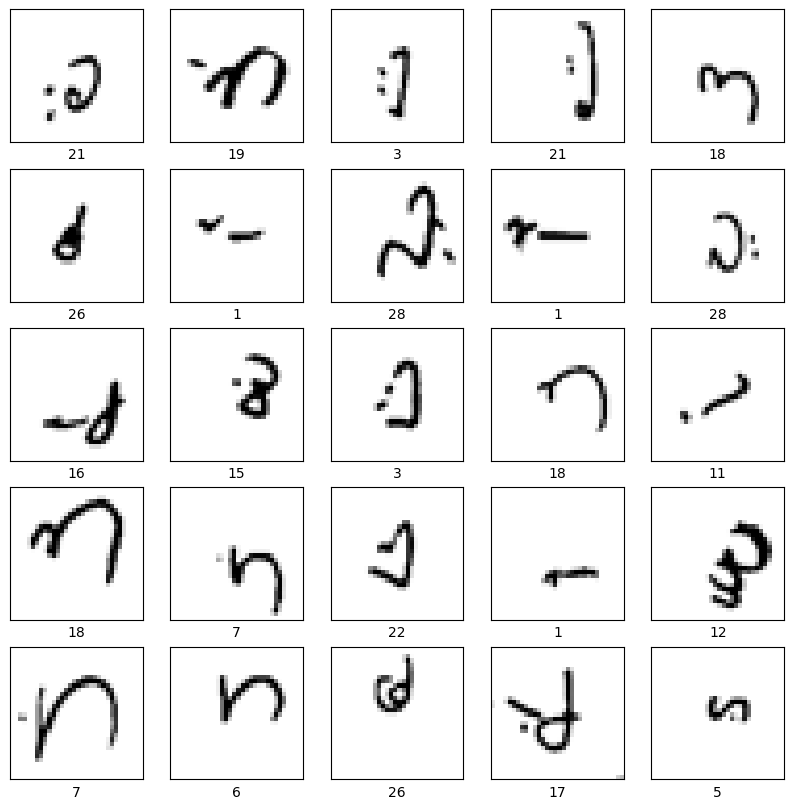

Images have been vertically flipped for all subsequent operations (e.g., model training).
Images in x_train and x_test have been rotated by 90 degrees clockwise as a preprocessing step.
Shape of x_train after fixed rotation: (13439, 32, 32, 1)
Shape of x_test after fixed rotation: (3359, 32, 32, 1)


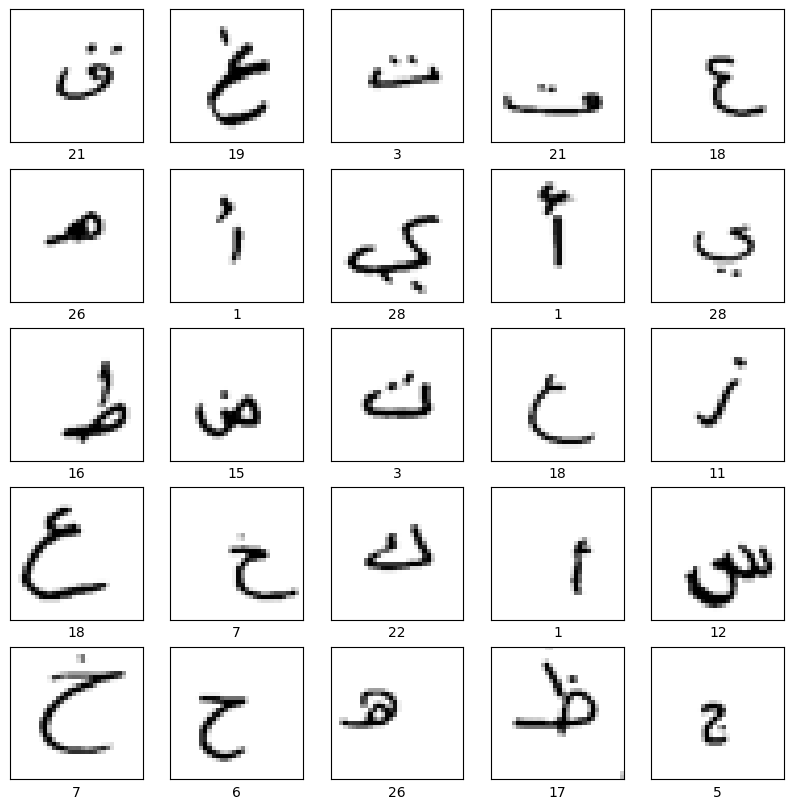

In [ ]:
import numpy as np
from scipy.ndimage import rotate
from skimage.transform import resize
import matplotlib.pyplot as plt
import random

# Convert image DataFrames to NumPy arrays
x_train_initial = train_images_df.values
x_test_initial = test_images_df.values

# Reshape image arrays to (samples, 32, 32, 1)
x_train_initial = x_train_initial.reshape(-1, 32, 32, 1)
x_test_initial = x_test_initial.reshape(-1, 32, 32, 1)

# Normalize pixel values to 0-1 range
x_train_initial = x_train_initial / 255.0
x_test_initial = x_test_initial / 255.0

print("Image data successfully converted, reshaped, and normalized.")
# print shapes
print("Shape of x_train_initial: ", x_train_initial.shape)
print("Shape of x_test_initial: ", x_test_initial.shape)

# Function to rotate a single image by a fixed angle
def rotate_single_image(image_array, angle_degrees):
    # scipy.ndimage.rotate expects a 2D or 3D array, so we remove the channel dimension for rotation
    # and then add it back. The reshape=False prevents automatic resizing of the output.
    # mode='nearest' fills new pixels with the nearest value.
    # order=1 for bilinear interpolation.
    rotated_image = rotate(image_array[:, :, 0], angle_degrees, reshape=False, mode='nearest', order=1)
    return rotated_image[:, :, np.newaxis] # Add the channel dimension back

random_indexes = random.sample(range(len(x_train_initial)), 25)
#show raw images
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train_initial[random_indexes[i]], cmap=plt.cm.binary)
  plt.xlabel(train_labels_df.iloc[random_indexes[i], 0])
plt.show()

# Apply 45 degree clockwise rotation to x_train and x_test
# Positive angle for scipy.ndimage.rotate is counter-clockwise. For clockwise, use a negative angle.
rotation_angle_degrees = 90 # For clockwise rotation

x_train_rotated_flipped = np.array([rotate_single_image(img, rotation_angle_degrees) for img in x_train_initial])
x_test_rotated_flipped = np.array([rotate_single_image(img, rotation_angle_degrees) for img in x_test_initial])
# Vertically flip images to correct orientation (this modifies the original x_train and x_test)
x_train_rotated_flipped = x_train_rotated_flipped[:, ::-1, :, :]
x_test_rotated_flipped = x_test_rotated_flipped[:, ::-1, :, :]
print("Images have been vertically flipped for all subsequent operations (e.g., model training).")

print(f"Images in x_train and x_test have been rotated by {rotation_angle_degrees} degrees clockwise as a preprocessing step.")
print("Shape of x_train after fixed rotation:", x_train_rotated_flipped.shape)
print("Shape of x_test after fixed rotation:", x_test_rotated_flipped.shape)


plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train_rotated_flipped[random_indexes[i]], cmap=plt.cm.binary)
  plt.xlabel(train_labels_df.iloc[random_indexes[i], 0])
plt.show()

Small noise components removed from images.
Shape of x_train_cleaned: (13439, 32, 32, 1)
Shape of x_test_cleaned: (3359, 32, 32, 1)
Number of cleaned images 363


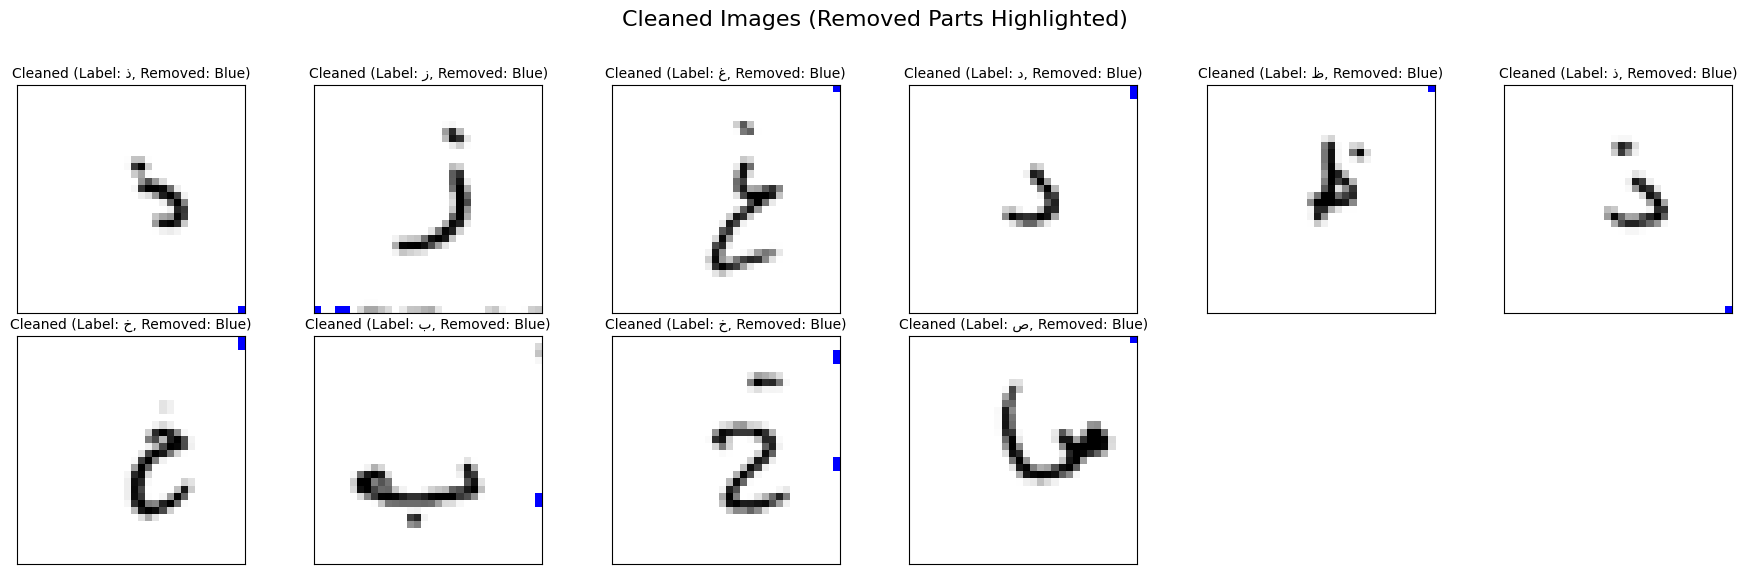

In [ ]:
from skimage.measure import label, regionprops
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors
from scipy.ndimage import distance_transform_edt # New import for distance calculation
import math

# Define the Arabic alphabet for display (adjust if your labels are 0-indexed differently)
arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'r', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Function to remove small connected components (noise) from an image based on area and proximity
def remove_small_components(image_array, threshold_area=3, proximity_threshold=5): # Increased proximity_threshold
    if image_array.ndim == 3 and image_array.shape[2] == 1:
        image_2d = image_array[:, :, 0]
    elif image_array.ndim == 2:
        image_2d = image_array
    else:
        raise ValueError("Expected a grayscale image (2D or 3D with 1 channel).")

    # Label connected components
    labeled_image = label(image_2d > 0.0) # Threshold to get binary image
    regions = regionprops(labeled_image)

    if not regions:
        return np.zeros_like(image_2d)[:, :, np.newaxis] # Return empty if no components found, with channel dim

    # Find the largest component (assumed to be the main character)
    largest_region = max(regions, key=lambda r: r.area)

    # Create a new image containing only the retained components
    cleaned_image = np.zeros_like(image_2d, dtype=image_2d.dtype)

    # Retain the largest component unconditionally
    cleaned_image[labeled_image == largest_region.label] = image_2d[labeled_image == largest_region.label]

    # Create a binary mask for the largest component
    largest_component_mask = (labeled_image == largest_region.label)

    # Compute Euclidean distance transform from the largest component. This gives the distance from
    # each pixel to the nearest pixel within the largest component.
    distance_from_largest = distance_transform_edt(~largest_component_mask)

    # Iterate through other components
    for region in regions:
        if region != largest_region: # Don't re-process the largest component
            if region.area >= threshold_area:
                # Keep components that are large enough, regardless of proximity
                cleaned_image[labeled_image == region.label] = image_2d[labeled_image == region.label]
            else:
                # For small components, check their proximity to the largest component
                small_component_mask = (labeled_image == region.label)

                # Find the minimum distance from any pixel of this small component to the largest component
                # If the small component overlaps with the largest component, min_dist_to_largest will be 0
                min_dist_to_largest = np.min(distance_from_largest[small_component_mask])

                if min_dist_to_largest <= proximity_threshold:
                    # If it's close enough (within the proximity_threshold), keep it
                    cleaned_image[labeled_image == region.label] = image_2d[labeled_image == region.label]

    return cleaned_image[:, :, np.newaxis] # Add channel dimension back

# Apply noise removal to the rotated and flipped images
x_train_cleaned = np.array([remove_small_components(img) for img in x_train_rotated_flipped])
x_test_cleaned = np.array([remove_small_components(img) for img in x_test_rotated_flipped])

print("Small noise components removed from images.")
print(f"Shape of x_train_cleaned: {x_train_cleaned.shape}")
print(f"Shape of x_test_cleaned: {x_test_cleaned.shape}")

# Prepare a list of indices where cleaning actually removed something
cleaned_indices_to_show = []
for idx in range(len(x_train_rotated_flipped)):
    original_img_flat = x_train_rotated_flipped[idx].flatten()
    cleaned_img_flat = x_train_cleaned[idx].flatten()
    if not np.array_equal(original_img_flat, cleaned_img_flat): # Check if any pixels were removed
        cleaned_indices_to_show.append(idx)
print('Number of cleaned images', len(cleaned_indices_to_show))

num_samples_to_show = min(10, len(cleaned_indices_to_show)) # Limit to 40 for practical display

num_cols = 6 # Desired number of columns
num_rows = math.ceil(num_samples_to_show / num_cols)

plt.figure(figsize=(num_cols * 3, num_rows * 3)) # Adjust figure size for multiple columns

if num_samples_to_show == 0:
    print("No images found with removed noise to display.")
else:
    for i in range(num_samples_to_show):
        random_index = cleaned_indices_to_show[random.randint(0, len(cleaned_indices_to_show) - 1)]

        original_img = x_train_rotated_flipped[random_index].squeeze()
        cleaned_img = x_train_cleaned[random_index].squeeze()
        label_value = train_labels_df.iloc[random_index, 0] # Get the numerical label
        arabic_char = arabic_letters[label_value - 1] # Convert to 0-indexed for arabic_letters list

        # Create a masked array for the removed parts (pixels present in original but not in cleaned)
        removed_parts = (original_img > 0) & (cleaned_img == 0)
        removed_overlay = np.zeros(original_img.shape + (4,)) # RGBA
        removed_overlay[removed_parts] = [0, 0, 1, 1] # Blue color with full alpha

        # Cleaned image with removed parts highlighted
        plt.subplot(num_rows, num_cols, i + 1) # Changed to multiple columns
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(cleaned_img, cmap=plt.cm.binary)
        # Overlay removed parts in blue
        plt.imshow(removed_overlay)
        plt.title(f"Cleaned (Label: {arabic_char}, Removed: Blue)", fontsize=10)

    plt.suptitle('Cleaned Images (Removed Parts Highlighted)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

/tmp/ipython-input-1323367333.py:44: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray((image_array_2d * 255).astype(np.uint8), mode='L')


Images cropped and directly scaled to (32, 32, 1).
Shape of x_train_scaled: (13439, 32, 32, 1)
Shape of x_test_scaled: (3359, 32, 32, 1)


/tmp/ipython-input-1323367333.py:75: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray((image_array_2d * 255).astype(np.uint8), mode='L')


Images cropped, aspect ratio preserved, and padded to (32, 32, 1).
Shape of x_train_padded: (13439, 32, 32, 1)
Shape of x_test_padded: (3359, 32, 32, 1)


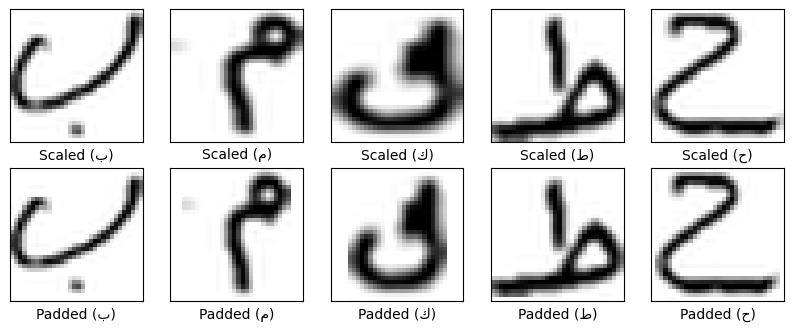

In [ ]:
import numpy as np
from PIL import Image

# Define the Arabic alphabet for display (adjust if your labels are 0-indexed differently)
arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

def crop_image_to_bbox(image_array):
    """Crops an image to the bounding box of its non-zero pixels."""
    # Ensure image_array is 2D for processing by PIL.Image.fromarray
    if image_array.ndim == 3 and image_array.shape[2] == 1:
        image_2d = image_array[:, :, 0]
    elif image_array.ndim == 2:
        image_2d = image_array
    else:
        raise ValueError("Expected a grayscale image (2D or 3D with 1 channel).")

    # Find the coordinates of non-zero pixels
    coords = np.argwhere(image_2d > 0)

    # If there are no non-zero pixels, return a blank 2D array of the same initial size
    if coords.size == 0:
        return np.zeros(image_2d.shape, dtype=image_2d.dtype)

    # Get the bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Crop the image using slicing
    cropped_image = image_2d[x_min:x_max+1, y_min:y_max+1]

    return cropped_image

def resize_image_direct_scale(image_array, target_size=(32, 32)):
    """Resizes an image directly to the target_size using PIL.Image.LANCZOS."""
    # Ensure the array is strictly 2D by squeezing any singleton dimensions
    image_array_2d = np.squeeze(image_array)

    if image_array_2d.ndim != 2:
        raise ValueError(f"Expected a 2D grayscale image for resizing, but got {image_array_2d.ndim} dimensions.")

    # Explicitly set mode='L' for grayscale images
    img = Image.fromarray((image_array_2d * 255).astype(np.uint8), mode='L')
    resized_img = img.resize(target_size, Image.LANCZOS)
    return np.array(resized_img) / 255.0

def resize_image_with_padding(image_array, target_size=(32, 32), pad_value=0.0):
    """Resizes an image while preserving aspect ratio, then pads to target_size."""
    # Ensure the array is strictly 2D by squeezing any singleton dimensions
    image_array_2d = np.squeeze(image_array)

    if image_array_2d.ndim != 2:
        raise ValueError(f"Expected a 2D grayscale image for resizing, but got {image_array_2d.ndim} dimensions.")

    h, w = image_array_2d.shape
    target_h, target_w = target_size

    # Handle empty or single-pixel images gracefully
    if h == 0 or w == 0:
        return np.full(target_size, pad_value, dtype=np.float32)

    # Calculate aspect ratio and scaling factor
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Ensure new_w and new_h are at least 1 to avoid issues with PIL resize, unless original is 0
    new_w = max(1, new_w) if w > 0 else 0
    new_h = max(1, new_h) if h > 0 else 0

    if new_w == 0 or new_h == 0: # If after scaling, dimensions become zero, return a blank target image
        return np.full(target_size, pad_value, dtype=np.float32)

    # Resize the image with preserved aspect ratio, explicitly setting mode='L'
    img = Image.fromarray((image_array_2d * 255).astype(np.uint8), mode='L')
    resized_img = img.resize((new_w, new_h), Image.LANCZOS)
    resized_img_array = np.array(resized_img) / 255.0

    # Create a new canvas with pad_value
    padded_img = np.full(target_size, pad_value, dtype=np.float32)

    # Paste the resized image onto the center of the canvas
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2

    # Correctly paste the resized image. resized_img_array will have shape (new_h, new_w)
    padded_img[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_img_array

    return padded_img

# --- Apply cropping and resizing to x_train and x_test (using the cleaned images) ---

# Option 1: Crop and direct scale
x_train_scaled = np.array([resize_image_direct_scale(crop_image_to_bbox(img)) for img in x_train_cleaned])
x_test_scaled = np.array([resize_image_direct_scale(crop_image_to_bbox(img)) for img in x_test_cleaned])

# Add the channel dimension back for compatibility with the model
x_train_scaled = x_train_scaled.reshape(-1, 32, 32, 1)
x_test_scaled = x_test_scaled.reshape(-1, 32, 32, 1)

print("Images cropped and directly scaled to (32, 32, 1).")
print("Shape of x_train_scaled:", x_train_scaled.shape)
print("Shape of x_test_scaled:", x_test_scaled.shape)

# Option 2: Crop and resize with padding
x_train_padded = np.array([resize_image_with_padding(crop_image_to_bbox(img)) for img in x_train_cleaned])
x_test_padded = np.array([resize_image_with_padding(crop_image_to_bbox(img)) for img in x_test_cleaned])

# Add the channel dimension back for compatibility with the model
x_train_padded = x_train_padded.reshape(-1, 32, 32, 1)
x_test_padded = x_test_padded.reshape(-1, 32, 32, 1)

print("Images cropped, aspect ratio preserved, and padded to (32, 32, 1).")
print("Shape of x_train_padded:", x_train_padded.shape)
print("Shape of x_test_padded:", x_test_padded.shape)

# x_train = x_train_scaled
# x_test = x_test_padded # Set x_test to x_test_padded
x_train = x_train_padded
x_test = x_test_padded

# plot 5 randomly chosen images for each resizing method
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(10, 10))
for i in range(5):
  random_index = random.randint(0, len(x_train) - 1)
  label_value = train_labels_df.iloc[random_index, 0]
  arabic_char = arabic_letters[label_value - 1]
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train_scaled[random_index], cmap=plt.cm.binary)
  plt.xlabel(f"Scaled ({arabic_char})")
  plt.subplot(5, 5, i+6)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train_padded[random_index], cmap=plt.cm.binary)
  plt.xlabel(f"Padded ({arabic_char})")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Instantiate KFold with 5 splits, shuffle, and a fixed random state
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("KFold object instantiated and lists for fold indices prepared.")

fold_no = 1
for train_index, val_index in kf.split(x_train, y_train):
    # Split data for the current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    print(f"Fold {fold_no}: Training data shape: {x_train_fold.shape}, Validation data shape: {x_val_fold.shape}")
    print(f"Fold {fold_no}: Training labels shape: {y_train_fold.shape}, Validation labels shape: {y_val_fold.shape}")
    fold_no += 1

print("Data successfully split into 5 folds using KFold.")

KFold object instantiated and lists for fold indices prepared.
Fold 1: Training data shape: (10751, 32, 32, 1), Validation data shape: (2688, 32, 32, 1)
Fold 1: Training labels shape: (10751, 28), Validation labels shape: (2688, 28)
Fold 2: Training data shape: (10751, 32, 32, 1), Validation data shape: (2688, 32, 32, 1)
Fold 2: Training labels shape: (10751, 28), Validation labels shape: (2688, 28)
Fold 3: Training data shape: (10751, 32, 32, 1), Validation data shape: (2688, 32, 32, 1)
Fold 3: Training labels shape: (10751, 28), Validation labels shape: (2688, 28)
Fold 4: Training data shape: (10751, 32, 32, 1), Validation data shape: (2688, 32, 32, 1)
Fold 4: Training labels shape: (10751, 28), Validation labels shape: (2688, 28)
Fold 5: Training data shape: (10752, 32, 32, 1), Validation data shape: (2687, 32, 32, 1)
Fold 5: Training labels shape: (10752, 28), Validation labels shape: (2687, 28)
Data successfully split into 5 folds using KFold.



------------------------------------------------------------------------
Training for Fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Best Validation Accuracy: 0.9821, Best Validation Loss: 0.1016


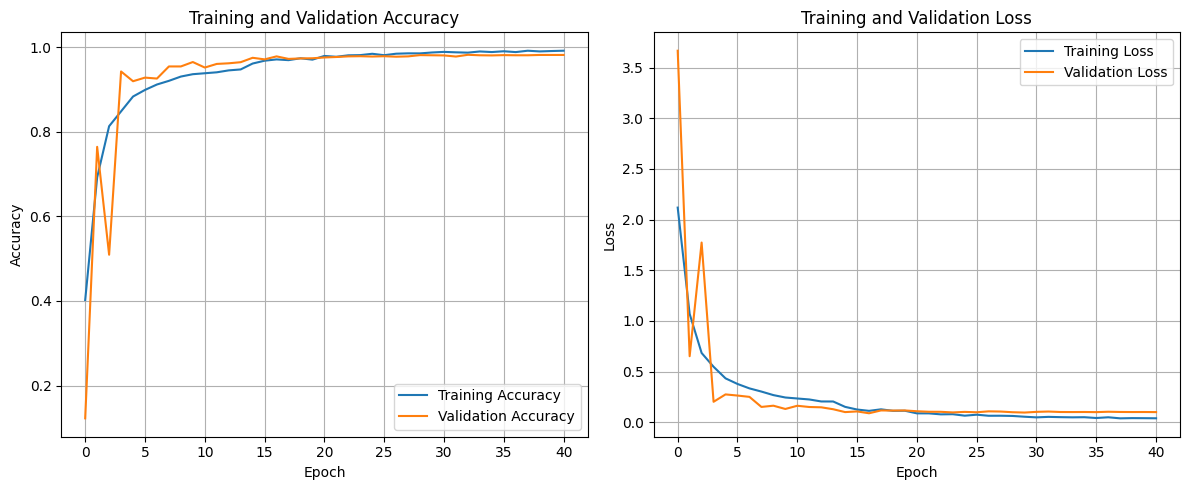


------------------------------------------------------------------------
Training for Fold 2...
Fold 2 - Best Validation Accuracy: 0.9792, Best Validation Loss: 0.0917

------------------------------------------------------------------------
Training for Fold 3...
Fold 3 - Best Validation Accuracy: 0.9821, Best Validation Loss: 0.0876

------------------------------------------------------------------------
Training for Fold 4...
Fold 4 - Best Validation Accuracy: 0.9836, Best Validation Loss: 0.0785

------------------------------------------------------------------------
Training for Fold 5...
Fold 5 - Best Validation Accuracy: 0.9814, Best Validation Loss: 0.1026

------------------------------------------------------------------------
5-fold cross-validation training complete. Metrics stored for each fold.

Average Best Validation Accuracy across all folds: 0.9817
Average Best Validation Loss across all folds: 0.0875
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Predictions on the test

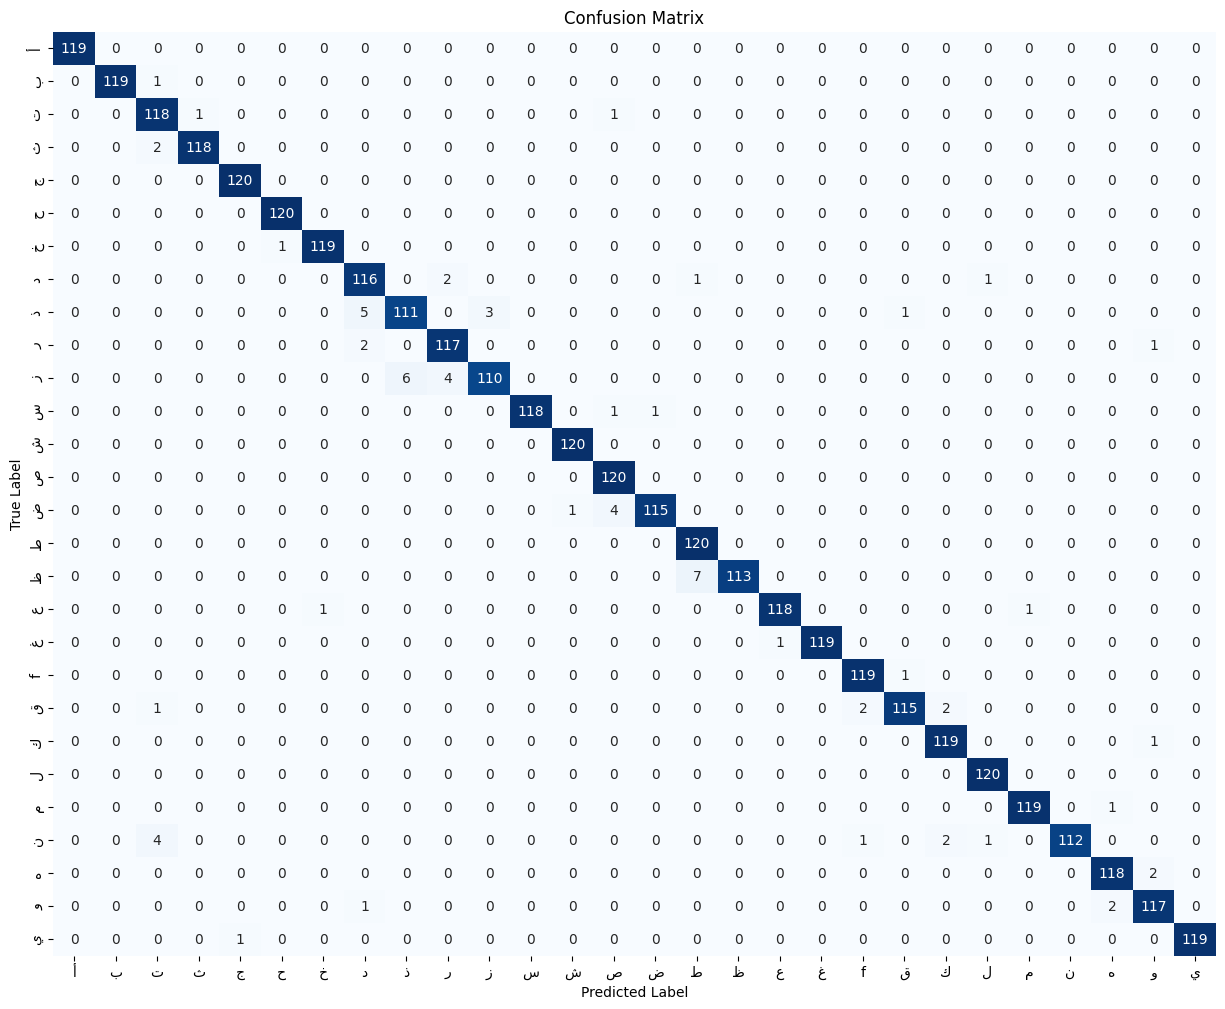

Confusion matrix computed and displayed successfully with Arabic letter labels.


In [ ]:
################## FULL AVERAGE POOLING ########################### ye?
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to build the model architecture
def build_cnn_model(input_shape=(32, 32, 1), num_classes=28):
    tf.random.set_seed(42)
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),

        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


# Initialize lists to store metrics for each fold
all_acc_per_fold = []
all_loss_per_fold = []
all_val_acc_per_fold = []
all_val_loss_per_fold = []

batch_size = 32
epochs = 200

fold_no = 1
for train_index, val_index in kf.split(x_train, y_train):
    print(f"\n------------------------------------------------------------------------")
    print(f"Training for Fold {fold_no}...")

    # Split data for the current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,      # Leichte Rotation (Handschriften sind oft schief)
        horizontal_flip=False   # False, da arabische Buchstaben richtungsabhängig sind!
    )
    datagen.fit(x_train_fold)

    # Reinitialize and compile the model for the current fold
    model = build_cnn_model(input_shape=(32, 32, 1), num_classes=num_classes) # Assuming num_classes is defined
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Define callbacks for the current fold
    checkpoint_filepath_fold = f'best_model_fold_{fold_no}.keras'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_fold,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0 # Set to 0 to avoid verbose output for each fold
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=4, verbose=0, factor=0.5, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=0)
    steps_per_epoch_with_partial = math.ceil(x_train_fold.shape[0] / batch_size)

    # Train the model
    history = model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
        steps_per_epoch= steps_per_epoch_with_partial,
        verbose=0 # Set to 0 to avoid verbose output for each epoch
    )

    # Load the best model saved by ModelCheckpoint for evaluation (optional, but good practice)
    best_model_this_fold = tf.keras.models.load_model(checkpoint_filepath_fold)

    # Evaluate the best model on the validation set for this fold
    val_loss, val_accuracy = best_model_this_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    train_loss, train_accuracy = best_model_this_fold.evaluate(x_train_fold, y_train_fold, verbose=0)

    print(f"Fold {fold_no} - Best Validation Accuracy: {val_accuracy:.4f}, Best Validation Loss: {val_loss:.4f}")

    # Store history for plotting later
    all_acc_per_fold.append(history.history['accuracy'])
    all_val_acc_per_fold.append(history.history['val_accuracy'])
    all_loss_per_fold.append(history.history['loss'])
    all_val_loss_per_fold.append(history.history['val_loss'])

    if fold_no == 1:
      # Plot training history
      plt.figure(figsize=(12, 5))

      # Plot accuracy
      plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
      plt.plot(history.history['accuracy'], label='Training Accuracy')
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      # Plot loss
      plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

    fold_no += 1

print("\n------------------------------------------------------------------------")
print("5-fold cross-validation training complete. Metrics stored for each fold.")

# Calculate average of best validation accuracy and loss across all folds
# The best validation accuracy and corresponding loss for each fold are determined by EarlyStopping's restore_best_weights=True
# So we need to find the maximum validation accuracy and minimum validation loss from the history of each fold.

best_val_accuracies = [np.max(fold_acc) for fold_acc in all_val_acc_per_fold]
best_val_losses = [np.min(fold_loss) for fold_loss in all_val_loss_per_fold]

avg_best_val_accuracy = np.mean(best_val_accuracies)
avg_best_val_loss = np.mean(best_val_losses)

print(f"\nAverage Best Validation Accuracy across all folds: {avg_best_val_accuracy:.4f}")
print(f"Average Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the Arabic alphabet (assuming 0 corresponds to the first letter, 1 to the second, etc.)
# You might need to adjust this list based on the exact mapping of your dataset labels
# The common Arabic alphabet has 28 letters, often starting with Alif.
# Let's assume a standard ordering from 0 to 27.

best_model = tf.keras.models.load_model(checkpoint_filepath_fold)

# Make predictions on the test set
y_pred_encoded = best_model.predict(x_test)

print("Predictions on the test set made successfully.")

arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=arabic_letters, yticklabels=arabic_letters)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix computed and displayed successfully with Arabic letter labels.")

# Results without unaccidental Drawing Removal Preprocessing
# Average Best Validation Accuracy across all folds: 0.9818
# Average Best Validation Loss across all folds: 0.0886


------------------------------------------------------------------------
Training for Fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Best Validation Accuracy: 0.9810, Best Validation Loss: 0.0891


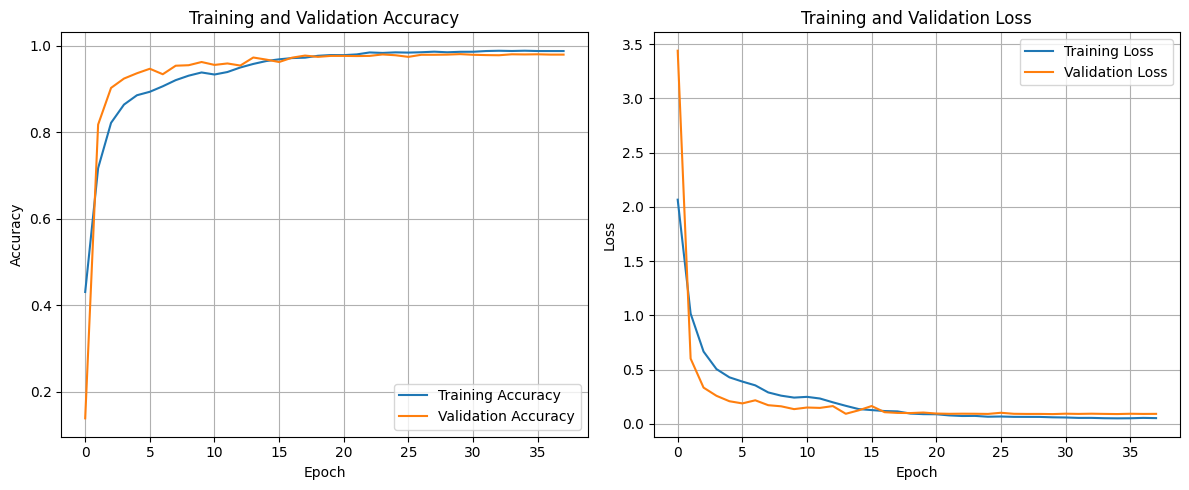


------------------------------------------------------------------------
Training for Fold 2...
Fold 2 - Best Validation Accuracy: 0.9818, Best Validation Loss: 0.1011

------------------------------------------------------------------------
Training for Fold 3...
Fold 3 - Best Validation Accuracy: 0.9844, Best Validation Loss: 0.0700

------------------------------------------------------------------------
Training for Fold 4...
Fold 4 - Best Validation Accuracy: 0.9810, Best Validation Loss: 0.0953

------------------------------------------------------------------------
Training for Fold 5...
Fold 5 - Best Validation Accuracy: 0.9814, Best Validation Loss: 0.0966

------------------------------------------------------------------------
5-fold cross-validation training complete. Metrics stored for each fold.

Average Best Validation Accuracy across all folds: 0.9819
Average Best Validation Loss across all folds: 0.0874
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
Predictions on the tes

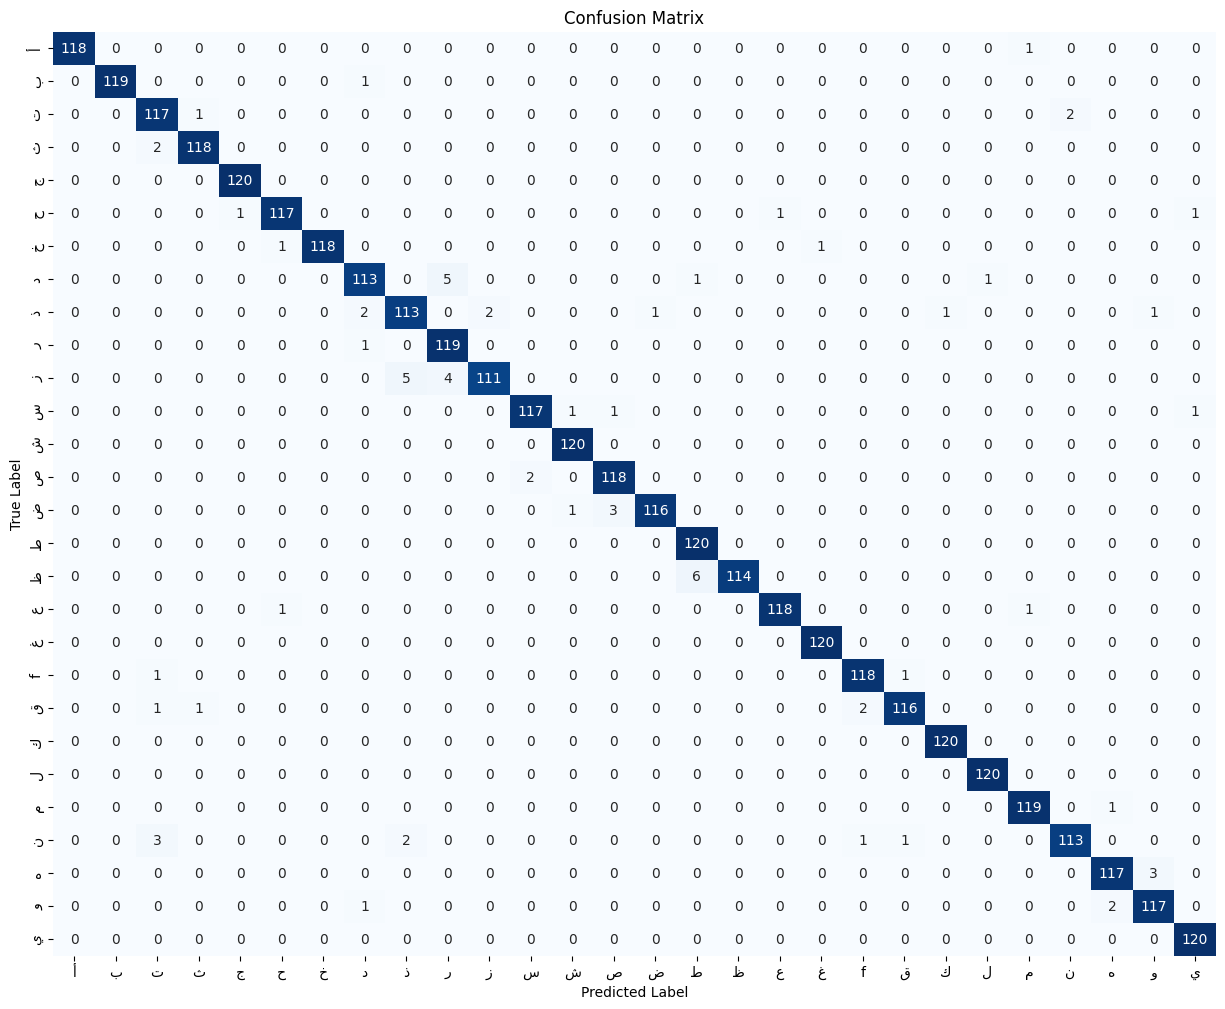

Confusion matrix computed and displayed successfully with Arabic letter labels.


In [ ]:
################## 1. 2. MAX 3. 4. AVERAGE POOLING ########################### nah. maybe yes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

# Function to build the model architecture
def build_cnn_model(input_shape=(32, 32, 1), num_classes=28):
    tf.random.set_seed(42)
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),

        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


# Initialize lists to store metrics for each fold
all_acc_per_fold = []
all_loss_per_fold = []
all_val_acc_per_fold = []
all_val_loss_per_fold = []

batch_size = 32
epochs = 200

fold_no = 1
for train_index, val_index in kf.split(x_train, y_train):
    print(f"\n------------------------------------------------------------------------")
    print(f"Training for Fold {fold_no}...")

    # Split data for the current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,      # Leichte Rotation (Handschriften sind oft schief)
        horizontal_flip=False   # False, da arabische Buchstaben richtungsabhängig sind!
    )
    datagen.fit(x_train_fold)

    # Reinitialize and compile the model for the current fold
    model = build_cnn_model(input_shape=(32, 32, 1), num_classes=num_classes) # Assuming num_classes is defined
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Define callbacks for the current fold
    checkpoint_filepath_fold = f'best_model_fold_{fold_no}.keras'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_fold,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0 # Set to 0 to avoid verbose output for each fold
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=0)
    steps_per_epoch_with_partial = math.ceil(x_train_fold.shape[0] / batch_size)

    # Train the model
    history = model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
        steps_per_epoch=steps_per_epoch_with_partial,
        verbose=0 # Set to 0 to avoid verbose output for each epoch
    )

    # Load the best model saved by ModelCheckpoint for evaluation (optional, but good practice)
    best_model_this_fold = tf.keras.models.load_model(checkpoint_filepath_fold)

    # Evaluate the best model on the validation set for this fold
    val_loss, val_accuracy = best_model_this_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    train_loss, train_accuracy = best_model_this_fold.evaluate(x_train_fold, y_train_fold, verbose=0)

    print(f"Fold {fold_no} - Best Validation Accuracy: {val_accuracy:.4f}, Best Validation Loss: {val_loss:.4f}")

    # Store history for plotting later
    all_acc_per_fold.append(history.history['accuracy'])
    all_val_acc_per_fold.append(history.history['val_accuracy'])
    all_loss_per_fold.append(history.history['loss'])
    all_val_loss_per_fold.append(history.history['val_loss'])

    if fold_no == 1:
      # Plot training history
      plt.figure(figsize=(12, 5))

      # Plot accuracy
      plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
      plt.plot(history.history['accuracy'], label='Training Accuracy')
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      # Plot loss
      plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

    fold_no += 1

print("\n------------------------------------------------------------------------")
print("5-fold cross-validation training complete. Metrics stored for each fold.")

# Calculate average of best validation accuracy and loss across all folds
# The best validation accuracy and corresponding loss for each fold are determined by EarlyStopping's restore_best_weights=True
# So we need to find the maximum validation accuracy and minimum validation loss from the history of each fold.

best_val_accuracies = [np.max(fold_acc) for fold_acc in all_val_acc_per_fold]
best_val_losses = [np.min(fold_loss) for fold_loss in all_val_loss_per_fold]

avg_best_val_accuracy = np.mean(best_val_accuracies)
avg_best_val_loss = np.mean(best_val_losses)

print(f"\nAverage Best Validation Accuracy across all folds: {avg_best_val_accuracy:.4f}")
print(f"Average Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the Arabic alphabet (assuming 0 corresponds to the first letter, 1 to the second, etc.)
# You might need to adjust this list based on the exact mapping of your dataset labels
# The common Arabic alphabet has 28 letters, often starting with Alif.
# Let's assume a standard ordering from 0 to 27.

best_model = tf.keras.models.load_model(checkpoint_filepath_fold)

# Make predictions on the test set
y_pred_encoded = best_model.predict(x_test)

print("Predictions on the test set made successfully.")

arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=arabic_letters, yticklabels=arabic_letters)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix computed and displayed successfully with Arabic letter labels.")


------------------------------------------------------------------------
Training for Fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Best Validation Accuracy: 0.9814, Best Validation Loss: 0.0998


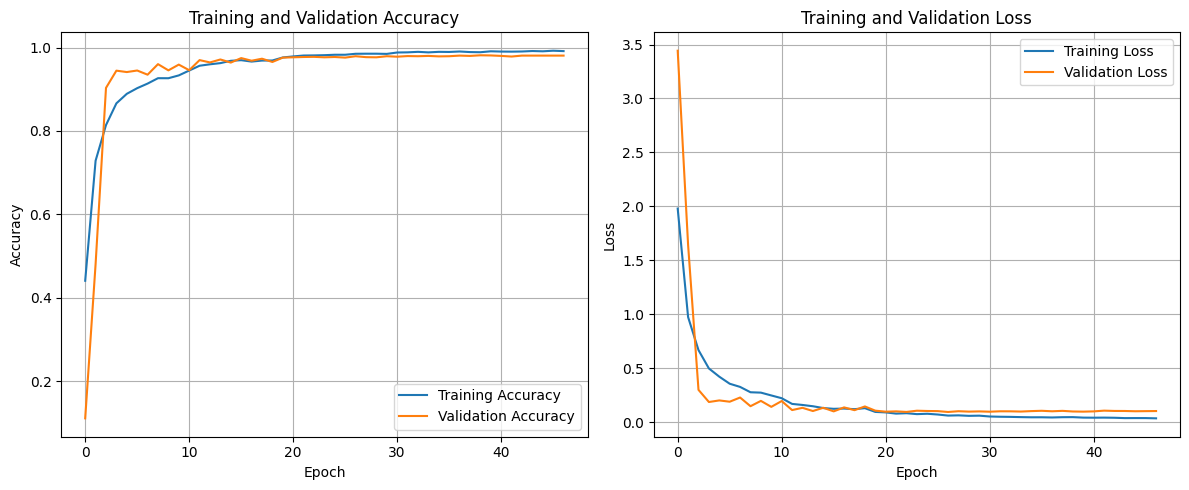


------------------------------------------------------------------------
Training for Fold 2...
Fold 2 - Best Validation Accuracy: 0.9814, Best Validation Loss: 0.0994

------------------------------------------------------------------------
Training for Fold 3...
Fold 3 - Best Validation Accuracy: 0.9829, Best Validation Loss: 0.0798

------------------------------------------------------------------------
Training for Fold 4...
Fold 4 - Best Validation Accuracy: 0.9855, Best Validation Loss: 0.0796

------------------------------------------------------------------------
Training for Fold 5...
Fold 5 - Best Validation Accuracy: 0.9821, Best Validation Loss: 0.0971

------------------------------------------------------------------------
5-fold cross-validation training complete. Metrics stored for each fold.

Average Best Validation Accuracy across all folds: 0.9827
Average Best Validation Loss across all folds: 0.0872
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Predictions on the test

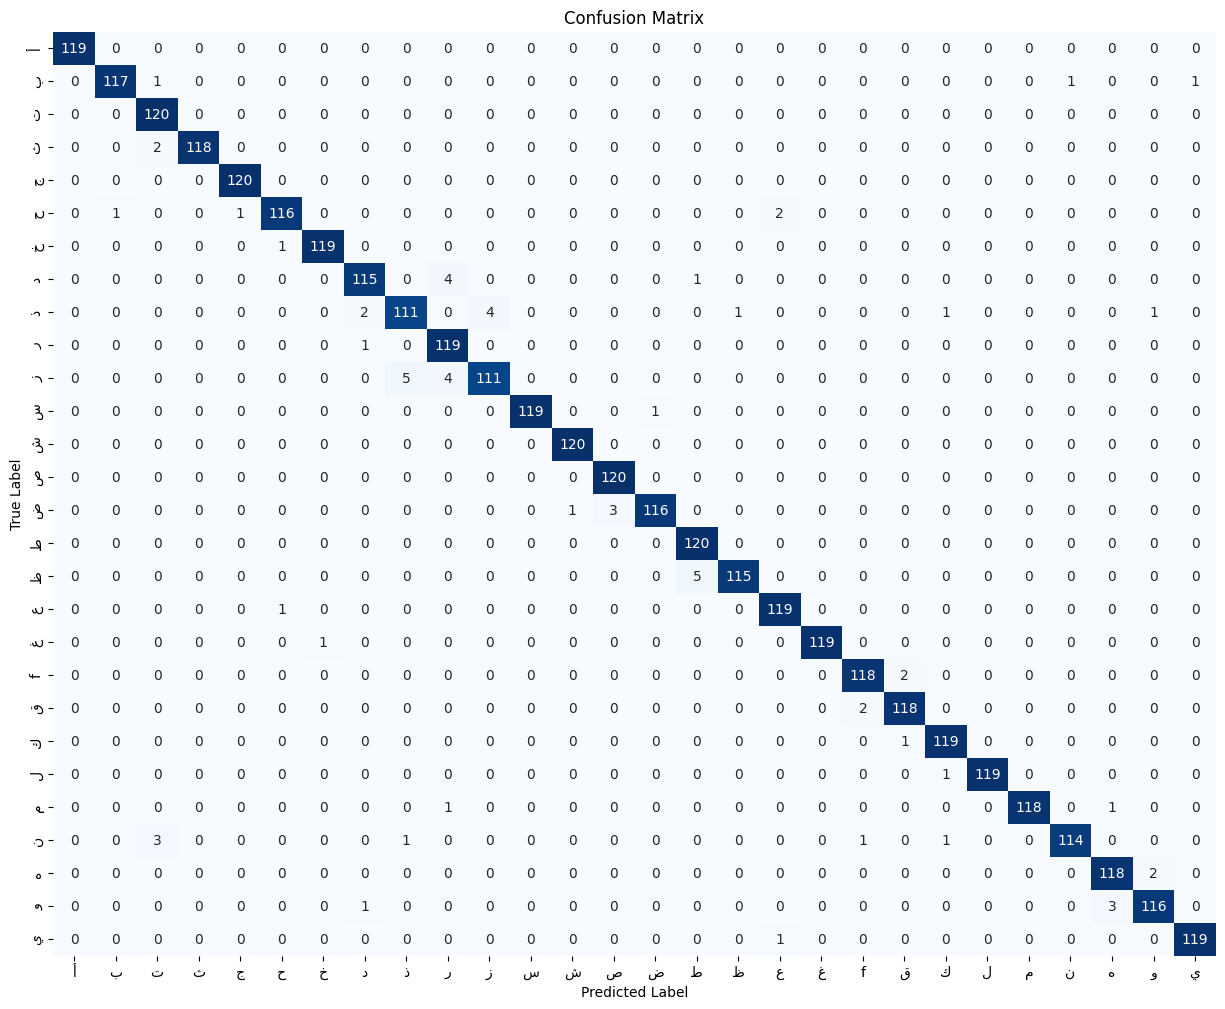

Confusion matrix computed and displayed successfully with Arabic letter labels.


In [ ]:
################## 1. MAX 2. 3. 4. AVERAGE POOLING & ########################### yes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to build the model architecture
def build_cnn_model(input_shape=(32, 32, 1), num_classes=28):
    tf.random.set_seed(42)
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),

        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


# Initialize lists to store metrics for each fold
all_acc_per_fold = []
all_loss_per_fold = []
all_val_acc_per_fold = []
all_val_loss_per_fold = []

batch_size = 32
epochs = 200

fold_no = 1
for train_index, val_index in kf.split(x_train, y_train):
    print(f"\n------------------------------------------------------------------------")
    print(f"Training for Fold {fold_no}...")

    # Split data for the current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,      # Leichte Rotation (Handschriften sind oft schief)
        horizontal_flip=False   # False, da arabische Buchstaben richtungsabhängig sind!
    )
    datagen.fit(x_train_fold)

    # Reinitialize and compile the model for the current fold
    model = build_cnn_model(input_shape=(32, 32, 1), num_classes=num_classes) # Assuming num_classes is defined
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Define callbacks for the current fold
    checkpoint_filepath_fold = f'best_model_fold_{fold_no}.keras'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_fold,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0 # Set to 0 to avoid verbose output for each fold
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=0)
    steps_per_epoch_with_partial = math.ceil(x_train_fold.shape[0] / batch_size)

    # Train the model
    history = model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
        steps_per_epoch= steps_per_epoch_with_partial,
        verbose=0 # Set to 0 to avoid verbose output for each epoch
    )

    # Load the best model saved by ModelCheckpoint for evaluation (optional, but good practice)
    best_model_this_fold = tf.keras.models.load_model(checkpoint_filepath_fold)

    # Evaluate the best model on the validation set for this fold
    val_loss, val_accuracy = best_model_this_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    train_loss, train_accuracy = best_model_this_fold.evaluate(x_train_fold, y_train_fold, verbose=0)

    print(f"Fold {fold_no} - Best Validation Accuracy: {val_accuracy:.4f}, Best Validation Loss: {val_loss:.4f}")

    # Store history for plotting later
    all_acc_per_fold.append(history.history['accuracy'])
    all_val_acc_per_fold.append(history.history['val_accuracy'])
    all_loss_per_fold.append(history.history['loss'])
    all_val_loss_per_fold.append(history.history['val_loss'])

    if fold_no == 1:
      # Plot training history
      plt.figure(figsize=(12, 5))

      # Plot accuracy
      plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
      plt.plot(history.history['accuracy'], label='Training Accuracy')
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      # Plot loss
      plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

    fold_no += 1

print("\n------------------------------------------------------------------------")
print("5-fold cross-validation training complete. Metrics stored for each fold.")

# Calculate average of best validation accuracy and loss across all folds
# The best validation accuracy and corresponding loss for each fold are determined by EarlyStopping's restore_best_weights=True
# So we need to find the maximum validation accuracy and minimum validation loss from the history of each fold.

best_val_accuracies = [np.max(fold_acc) for fold_acc in all_val_acc_per_fold]
best_val_losses = [np.min(fold_loss) for fold_loss in all_val_loss_per_fold]

avg_best_val_accuracy = np.mean(best_val_accuracies)
avg_best_val_loss = np.mean(best_val_losses)

print(f"\nAverage Best Validation Accuracy across all folds: {avg_best_val_accuracy:.4f}")
print(f"Average Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the Arabic alphabet (assuming 0 corresponds to the first letter, 1 to the second, etc.)
# You might need to adjust this list based on the exact mapping of your dataset labels
# The common Arabic alphabet has 28 letters, often starting with Alif.
# Let's assume a standard ordering from 0 to 27.

best_model = tf.keras.models.load_model(checkpoint_filepath_fold)

# Make predictions on the test set
y_pred_encoded = best_model.predict(x_test)

print("Predictions on the test set made successfully.")

arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=arabic_letters, yticklabels=arabic_letters)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix computed and displayed successfully with Arabic letter labels.")


------------------------------------------------------------------------
Training for Fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Best Validation Accuracy: 0.9784, Best Validation Loss: 0.1094


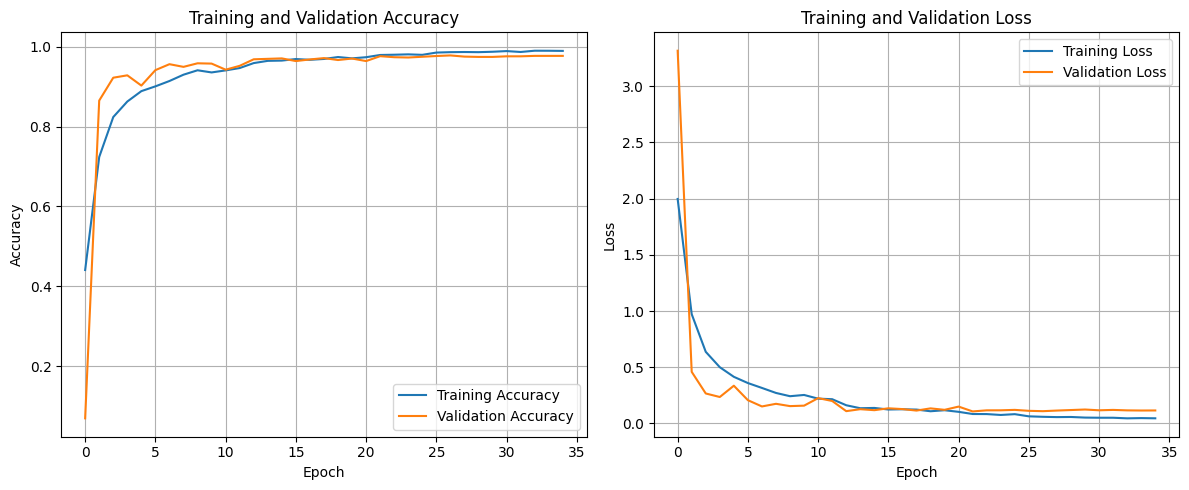


------------------------------------------------------------------------
Training for Fold 2...
Fold 2 - Best Validation Accuracy: 0.9777, Best Validation Loss: 0.1068

------------------------------------------------------------------------
Training for Fold 3...
Fold 3 - Best Validation Accuracy: 0.9825, Best Validation Loss: 0.0872

------------------------------------------------------------------------
Training for Fold 4...
Fold 4 - Best Validation Accuracy: 0.9818, Best Validation Loss: 0.1050

------------------------------------------------------------------------
Training for Fold 5...
Fold 5 - Best Validation Accuracy: 0.9799, Best Validation Loss: 0.1060

------------------------------------------------------------------------
5-fold cross-validation training complete. Metrics stored for each fold.

Average Best Validation Accuracy across all folds: 0.9801
Average Best Validation Loss across all folds: 0.0956
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Predictions on the test

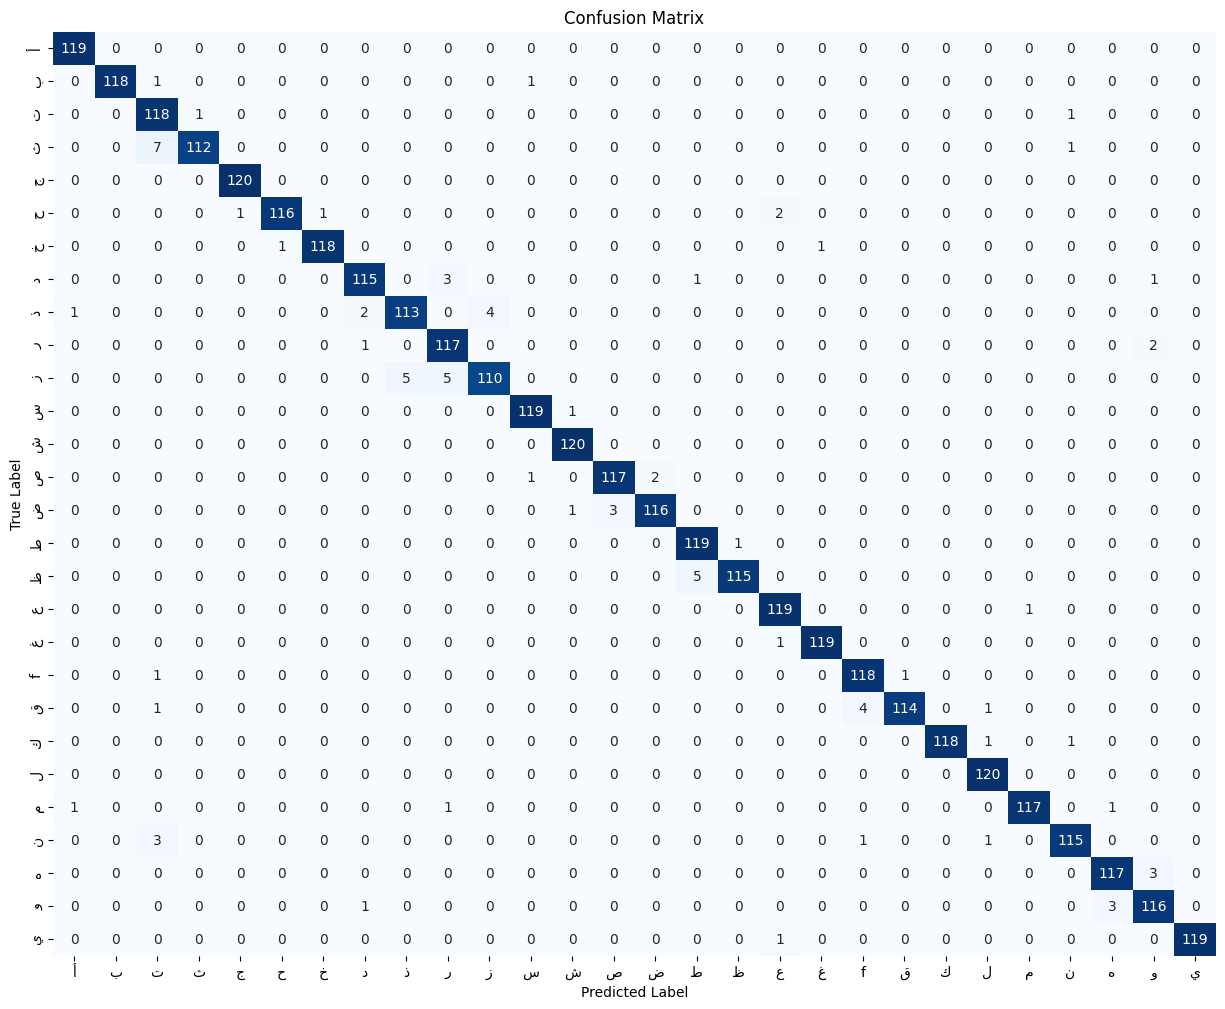

Confusion matrix computed and displayed successfully with Arabic letter labels.


In [ ]:
################## FULL MAX POOLING ########################### yes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

# Function to build the model architecture
def build_cnn_model(input_shape=(32, 32, 1), num_classes=28):
    tf.random.set_seed(42)
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),

        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


# Initialize lists to store metrics for each fold
all_acc_per_fold = []
all_loss_per_fold = []
all_val_acc_per_fold = []
all_val_loss_per_fold = []

batch_size = 32
epochs = 200

fold_no = 1
for train_index, val_index in kf.split(x_train, y_train):
    print(f"\n------------------------------------------------------------------------")
    print(f"Training for Fold {fold_no}...")

    # Split data for the current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,      # Leichte Rotation (Handschriften sind oft schief)
        horizontal_flip=False   # False, da arabische Buchstaben richtungsabhängig sind!
    )
    datagen.fit(x_train_fold)

    # Reinitialize and compile the model for the current fold
    model = build_cnn_model(input_shape=(32, 32, 1), num_classes=num_classes) # Assuming num_classes is defined
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Define callbacks for the current fold
    checkpoint_filepath_fold = f'best_model_fold_{fold_no}.keras'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_fold,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0 # Set to 0 to avoid verbose output for each fold
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=0)
    steps_per_epoch_with_partial = math.ceil(x_train_fold.shape[0] / batch_size)

    # Train the model
    history = model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
        steps_per_epoch=steps_per_epoch_with_partial,
        verbose=0 # Set to 0 to avoid verbose output for each epoch
    )

    # Load the best model saved by ModelCheckpoint for evaluation (optional, but good practice)
    best_model_this_fold = tf.keras.models.load_model(checkpoint_filepath_fold)

    # Evaluate the best model on the validation set for this fold
    val_loss, val_accuracy = best_model_this_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    train_loss, train_accuracy = best_model_this_fold.evaluate(x_train_fold, y_train_fold, verbose=0)

    print(f"Fold {fold_no} - Best Validation Accuracy: {val_accuracy:.4f}, Best Validation Loss: {val_loss:.4f}")

    # Store history for plotting later
    all_acc_per_fold.append(history.history['accuracy'])
    all_val_acc_per_fold.append(history.history['val_accuracy'])
    all_loss_per_fold.append(history.history['loss'])
    all_val_loss_per_fold.append(history.history['val_loss'])

    if fold_no == 1:
      # Plot training history
      plt.figure(figsize=(12, 5))

      # Plot accuracy
      plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
      plt.plot(history.history['accuracy'], label='Training Accuracy')
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      # Plot loss
      plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

    fold_no += 1

print("\n------------------------------------------------------------------------")
print("5-fold cross-validation training complete. Metrics stored for each fold.")

# Calculate average of best validation accuracy and loss across all folds
# The best validation accuracy and corresponding loss for each fold are determined by EarlyStopping's restore_best_weights=True
# So we need to find the maximum validation accuracy and minimum validation loss from the history of each fold.

best_val_accuracies = [np.max(fold_acc) for fold_acc in all_val_acc_per_fold]
best_val_losses = [np.min(fold_loss) for fold_loss in all_val_loss_per_fold]

avg_best_val_accuracy = np.mean(best_val_accuracies)
avg_best_val_loss = np.mean(best_val_losses)

print(f"\nAverage Best Validation Accuracy across all folds: {avg_best_val_accuracy:.4f}")
print(f"Average Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the Arabic alphabet (assuming 0 corresponds to the first letter, 1 to the second, etc.)
# You might need to adjust this list based on the exact mapping of your dataset labels
# The common Arabic alphabet has 28 letters, often starting with Alif.
# Let's assume a standard ordering from 0 to 27.

best_model = tf.keras.models.load_model(checkpoint_filepath_fold)

# Make predictions on the test set
y_pred_encoded = best_model.predict(x_test)

print("Predictions on the test set made successfully.")

arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=arabic_letters, yticklabels=arabic_letters)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Confusion matrix computed and displayed successfully with Arabic letter labels.")

Total misclassified images: 82


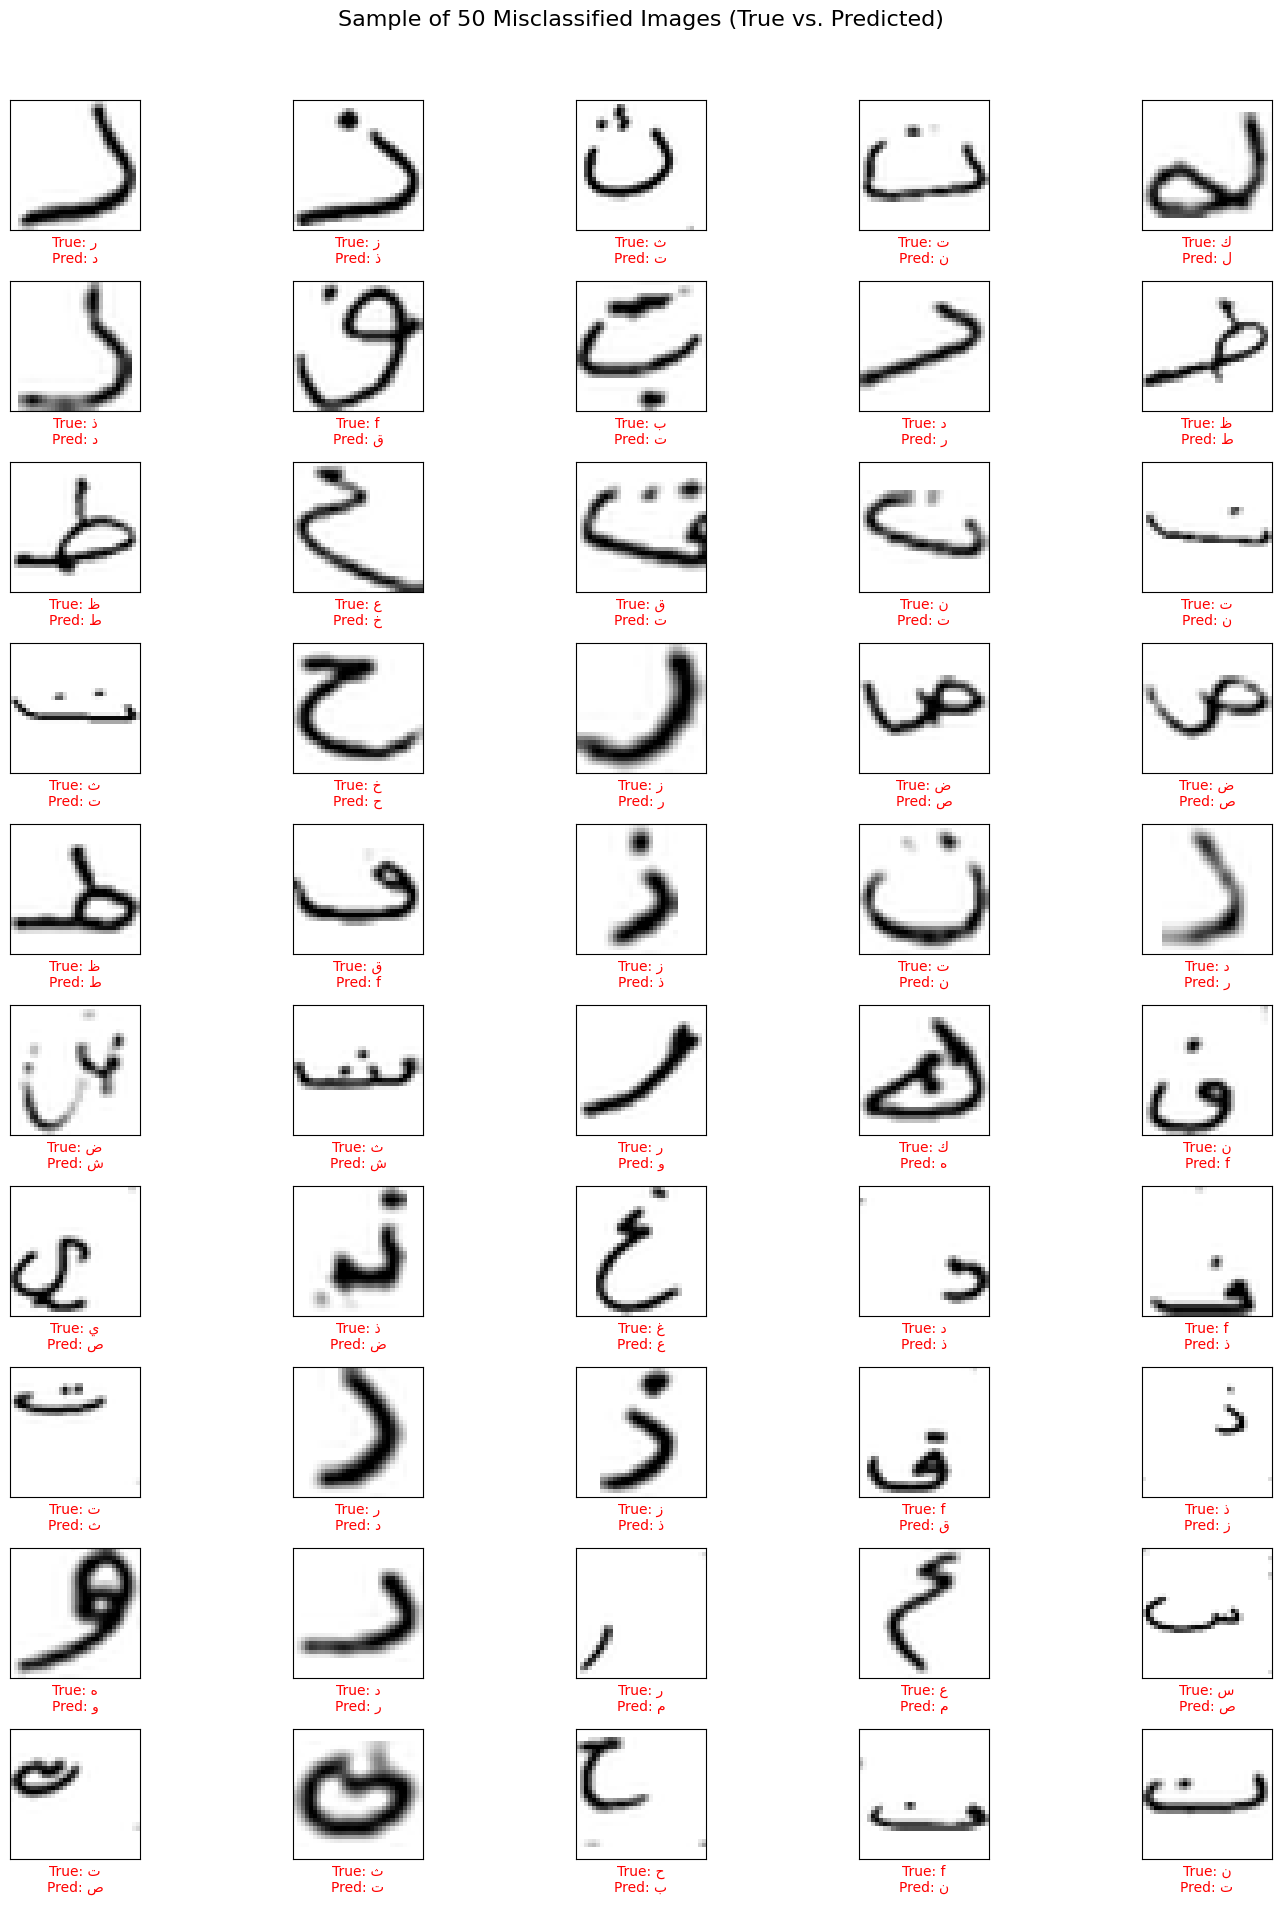

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Find indices of misclassified images
misclassified_indices = np.where(y_true_classes != y_pred_classes)[0]

print(f"Total misclassified images: {len(misclassified_indices)}")

# Display all misclassified images, up to a practical limit (e.g., 50 images)
num_display = min(50, len(misclassified_indices)) # Limit to 50 for practical display

plt.figure(figsize=(15, 2 * num_display / 5 if num_display > 0 else 3))

# Use a loop over all misclassified indices or a subset if too many
for i, index in enumerate(misclassified_indices):
    if i >= num_display: # Stop after num_display images
        break
    plt.subplot(num_display // 5 + (1 if num_display % 5 > 0 else 0), 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[index], cmap=plt.cm.binary)
    true_label = arabic_letters[y_true_classes[index]]
    pred_label = arabic_letters[y_pred_classes[index]]
    plt.xlabel(f"True: {true_label}\nPred: {pred_label}", color='red' if true_label != pred_label else 'black')
plt.suptitle(f'Sample of {num_display} Misclassified Images (True vs. Predicted)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Task
`new_cell_1`

## Model 1: Experiment with Lower Learning Rate

### Subtask:
Create and train a version of the 'Full Average Pooling' model using a slightly lower initial learning rate (e.g., 0.0005) for the Adam optimizer, using the existing K-Fold cross-validation setup.


**Reasoning**:
The subtask requires defining a CNN model, setting up K-fold cross-validation, training the model with a specific learning rate and callbacks, and then evaluating it, which involves a comprehensive code block. I will define the model architecture and the training loop in a single code block, as it is a logical and interconnected set of operations.




------------------------------------------------------------------------
Training for Fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Best Validation Accuracy: 0.9795, Best Validation Loss: 0.0953


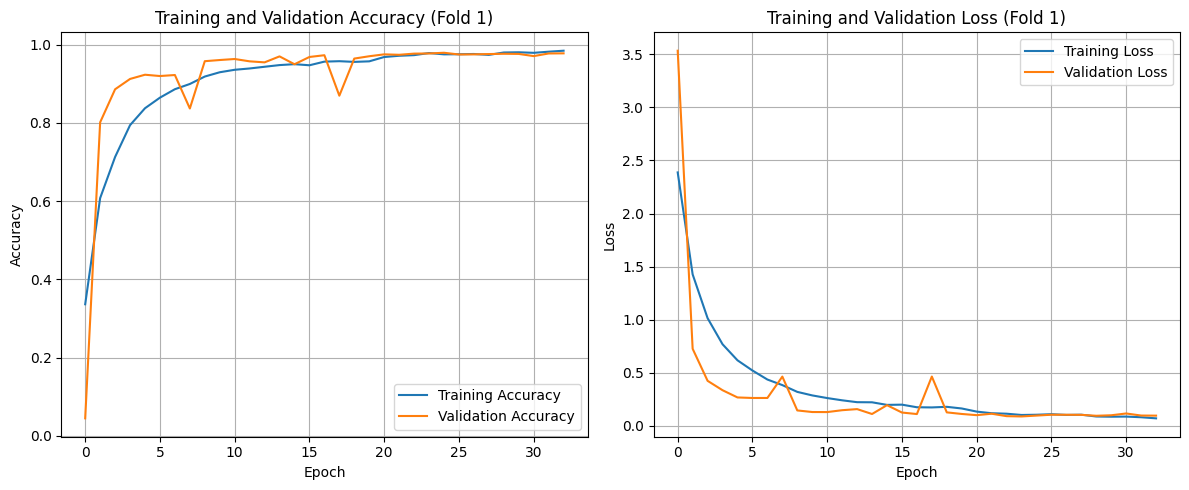


------------------------------------------------------------------------
Training for Fold 2...
Fold 2 - Best Validation Accuracy: 0.9844, Best Validation Loss: 0.0819

------------------------------------------------------------------------
Training for Fold 3...
Fold 3 - Best Validation Accuracy: 0.9825, Best Validation Loss: 0.0839

------------------------------------------------------------------------
Training for Fold 4...
Fold 4 - Best Validation Accuracy: 0.9844, Best Validation Loss: 0.0864

------------------------------------------------------------------------
Training for Fold 5...
Fold 5 - Best Validation Accuracy: 0.9788, Best Validation Loss: 0.1007

------------------------------------------------------------------------
5-fold cross-validation training complete. Metrics stored for each fold.

Average Best Validation Accuracy across all folds: 0.9819
Average Best Validation Loss across all folds: 0.0843
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Predictions on the test

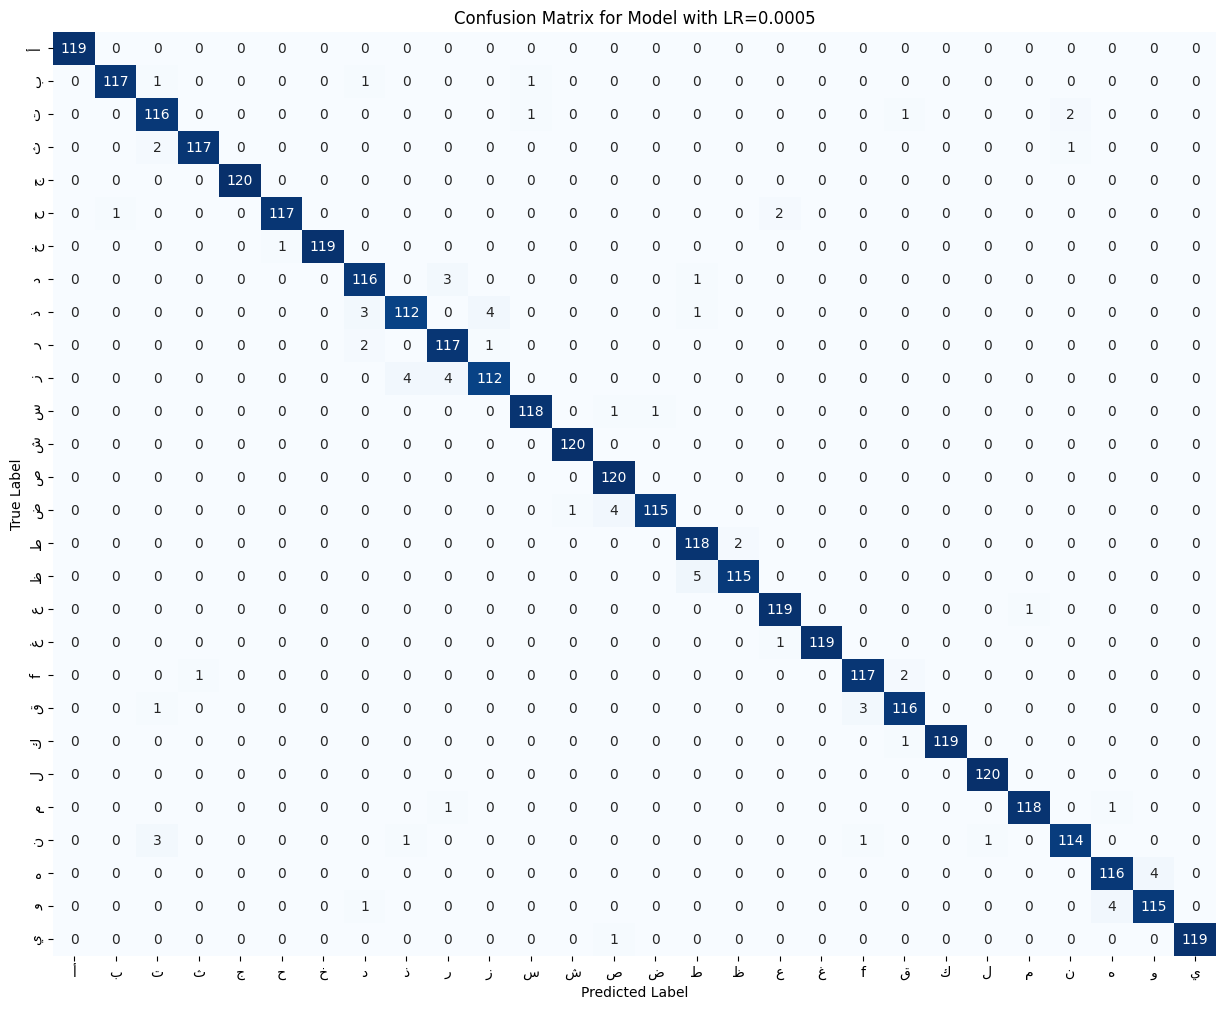

Confusion matrix computed and displayed successfully with Arabic letter labels.


In [ ]:
################## FULL AVERAGE POOLING with Lower Learning Rate ########################### yes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to build the model architecture (identical to Full Average Pooling)
def build_cnn_model(input_shape=(32, 32, 1), num_classes=28):
    tf.random.set_seed(42)
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),

        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


# Initialize lists to store metrics for each fold
all_acc_per_fold = []
all_loss_per_fold = []
all_val_acc_per_fold = []
all_val_loss_per_fold = []

batch_size = 32
epochs = 200
initial_learning_rate = 0.0005 # Lower learning rate as per subtask

fold_no = 1
for train_index, val_index in kf.split(x_train, y_train):
    print(f"\n------------------------------------------------------------------------")
    print(f"Training for Fold {fold_no}...")

    # Split data for the current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,      # Leichte Rotation (Handschriften sind oft schief)
        horizontal_flip=False   # False, da arabische Buchstaben richtungsabhängig sind!
    )
    datagen.fit(x_train_fold)

    # Reinitialize and compile the model for the current fold
    model = build_cnn_model(input_shape=(32, 32, 1), num_classes=num_classes) # Assuming num_classes is defined
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=initial_learning_rate), # Use the specified lower learning rate
        metrics=["accuracy"]
    )

    # Define callbacks for the current fold
    checkpoint_filepath_fold = f'best_model_fold_{fold_no}_lr_0005.keras'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_fold,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0 # Set to 0 to avoid verbose output for each fold
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=0)
    steps_per_epoch_with_partial = math.ceil(x_train_fold.shape[0] / batch_size)

    # Train the model
    history = model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
        steps_per_epoch= steps_per_epoch_with_partial,
        verbose=0 # Set to 0 to avoid verbose output for each epoch
    )

    # Load the best model saved by ModelCheckpoint for evaluation
    best_model_this_fold = tf.keras.models.load_model(checkpoint_filepath_fold)

    # Evaluate the best model on the validation set for this fold
    val_loss, val_accuracy = best_model_this_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    # train_loss, train_accuracy = best_model_this_fold.evaluate(x_train_fold, y_train_fold, verbose=0) # Not explicitly required by instructions to print

    print(f"Fold {fold_no} - Best Validation Accuracy: {val_accuracy:.4f}, Best Validation Loss: {val_loss:.4f}")

    # Store history for plotting later
    all_acc_per_fold.append(history.history['accuracy'])
    all_val_acc_per_fold.append(history.history['val_accuracy'])
    all_loss_per_fold.append(history.history['loss'])
    all_val_loss_per_fold.append(history.history['val_loss'])

    if fold_no == 1:
      # Plot training history for the first fold
      plt.figure(figsize=(12, 5))

      # Plot accuracy
      plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
      plt.plot(history.history['accuracy'], label='Training Accuracy')
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training and Validation Accuracy (Fold 1)')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      # Plot loss
      plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss (Fold 1)')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

    fold_no += 1

print("\n------------------------------------------------------------------------")
print("5-fold cross-validation training complete. Metrics stored for each fold.")

# Calculate average of best validation accuracy and loss across all folds
best_val_accuracies = [np.max(fold_acc) for fold_acc in all_val_acc_per_fold]
best_val_losses = [np.min(fold_loss) for fold_loss in all_val_loss_per_fold]

avg_best_val_accuracy = np.mean(best_val_accuracies)
avg_best_val_loss = np.mean(best_val_losses)

print(f"\nAverage Best Validation Accuracy across all folds: {avg_best_val_accuracy:.4f}")
print(f"Average Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

# Load the best model from the last fold for final evaluation on x_test
best_model = tf.keras.models.load_model(checkpoint_filepath_fold)

# Make predictions on the test set
y_pred_encoded = best_model.predict(x_test)

print("Predictions on the test set made successfully.")

arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=arabic_letters, yticklabels=arabic_letters)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model with LR=0.0005')
plt.show()

print("Confusion matrix computed and displayed successfully with Arabic letter labels.")



------------------------------------------------------------------------
Training for Fold 1...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 - Best Validation Accuracy: 0.9799, Best Validation Loss: 0.0827


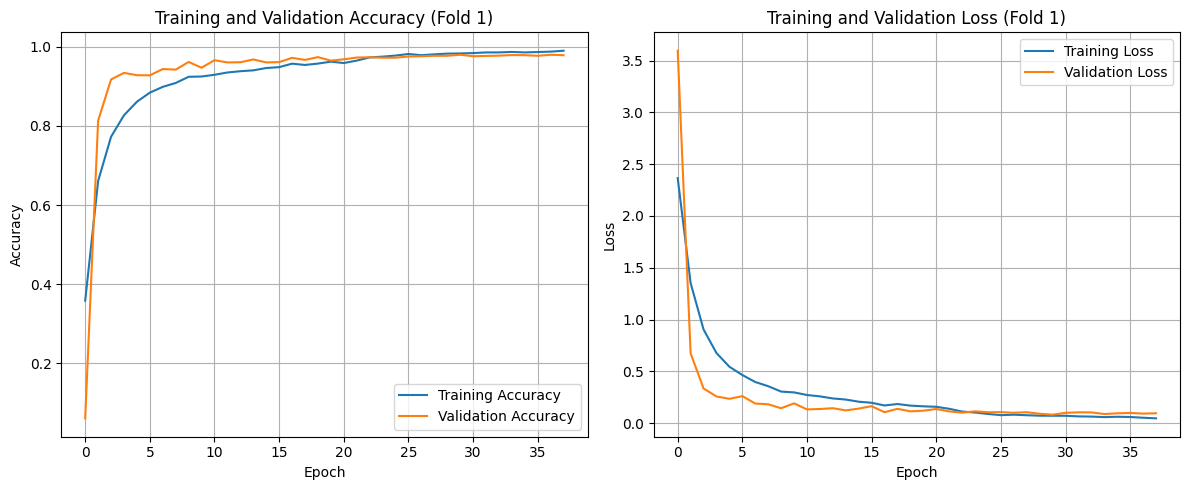


------------------------------------------------------------------------
Training for Fold 2...
Fold 2 - Best Validation Accuracy: 0.9825, Best Validation Loss: 0.0882

------------------------------------------------------------------------
Training for Fold 3...
Fold 3 - Best Validation Accuracy: 0.9840, Best Validation Loss: 0.0692

------------------------------------------------------------------------
Training for Fold 4...
Fold 4 - Best Validation Accuracy: 0.9825, Best Validation Loss: 0.0741

------------------------------------------------------------------------
Training for Fold 5...


In [ ]:
################## 1. Max rest AVERAGE POOLING with Lower Learning Rate ########################### yes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to build the model architecture (identical to Full Average Pooling)
def build_cnn_model(input_shape=(32, 32, 1), num_classes=28):
    tf.random.set_seed(42)
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),

        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.AveragePooling2D((2, 2)),
        keras.layers.BatchNormalization(),

        keras.layers.Flatten(),

        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),

        keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


# Initialize lists to store metrics for each fold
all_acc_per_fold = []
all_loss_per_fold = []
all_val_acc_per_fold = []
all_val_loss_per_fold = []

batch_size = 32
epochs = 200
initial_learning_rate = 0.0005 # Lower learning rate as per subtask

fold_no = 1
for train_index, val_index in kf.split(x_train, y_train):
    print(f"\n------------------------------------------------------------------------")
    print(f"Training for Fold {fold_no}...")

    # Split data for the current fold
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train_encoded[train_index], y_train_encoded[val_index]

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=10,      # Leichte Rotation (Handschriften sind oft schief)
        horizontal_flip=False   # False, da arabische Buchstaben richtungsabhängig sind!
    )
    datagen.fit(x_train_fold)

    # Reinitialize and compile the model for the current fold
    model = build_cnn_model(input_shape=(32, 32, 1), num_classes=num_classes) # Assuming num_classes is defined
    model.compile(
        loss="categorical_crossentropy",
        optimizer=Adam(learning_rate=initial_learning_rate), # Use the specified lower learning rate
        metrics=["accuracy"]
    )

    # Define callbacks for the current fold
    checkpoint_filepath_fold = f'best_model_fold_{fold_no}_lr_0005.keras'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_fold,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=0 # Set to 0 to avoid verbose output for each fold
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=0)
    steps_per_epoch_with_partial = math.ceil(x_train_fold.shape[0] / batch_size)

    # Train the model
    history = model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
        steps_per_epoch= steps_per_epoch_with_partial,
        verbose=0 # Set to 0 to avoid verbose output for each epoch
    )

    # Load the best model saved by ModelCheckpoint for evaluation
    best_model_this_fold = tf.keras.models.load_model(checkpoint_filepath_fold)

    # Evaluate the best model on the validation set for this fold
    val_loss, val_accuracy = best_model_this_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    # train_loss, train_accuracy = best_model_this_fold.evaluate(x_train_fold, y_train_fold, verbose=0) # Not explicitly required by instructions to print

    print(f"Fold {fold_no} - Best Validation Accuracy: {val_accuracy:.4f}, Best Validation Loss: {val_loss:.4f}")

    # Store history for plotting later
    all_acc_per_fold.append(history.history['accuracy'])
    all_val_acc_per_fold.append(history.history['val_accuracy'])
    all_loss_per_fold.append(history.history['loss'])
    all_val_loss_per_fold.append(history.history['val_loss'])

    if fold_no == 1:
      # Plot training history for the first fold
      plt.figure(figsize=(12, 5))

      # Plot accuracy
      plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
      plt.plot(history.history['accuracy'], label='Training Accuracy')
      plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training and Validation Accuracy (Fold 1)')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.grid(True)

      # Plot loss
      plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
      plt.plot(history.history['loss'], label='Training Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Training and Validation Loss (Fold 1)')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)

      plt.tight_layout()
      plt.show()

    fold_no += 1

print("\n------------------------------------------------------------------------")
print("5-fold cross-validation training complete. Metrics stored for each fold.")

# Calculate average of best validation accuracy and loss across all folds
best_val_accuracies = [np.max(fold_acc) for fold_acc in all_val_acc_per_fold]
best_val_losses = [np.min(fold_loss) for fold_loss in all_val_loss_per_fold]

avg_best_val_accuracy = np.mean(best_val_accuracies)
avg_best_val_loss = np.mean(best_val_losses)

print(f"\nAverage Best Validation Accuracy across all folds: {avg_best_val_accuracy:.4f}")
print(f"Average Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

# Load the best model from the last fold for final evaluation on x_test
best_model = tf.keras.models.load_model(checkpoint_filepath_fold)

# Make predictions on the test set
y_pred_encoded = best_model.predict(x_test)

print("Predictions on the test set made successfully.")

arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=arabic_letters, yticklabels=arabic_letters)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Model with LR=0.0005')
plt.show()

print("Confusion matrix computed and displayed successfully with Arabic letter labels.")


Total misclassified images: 79


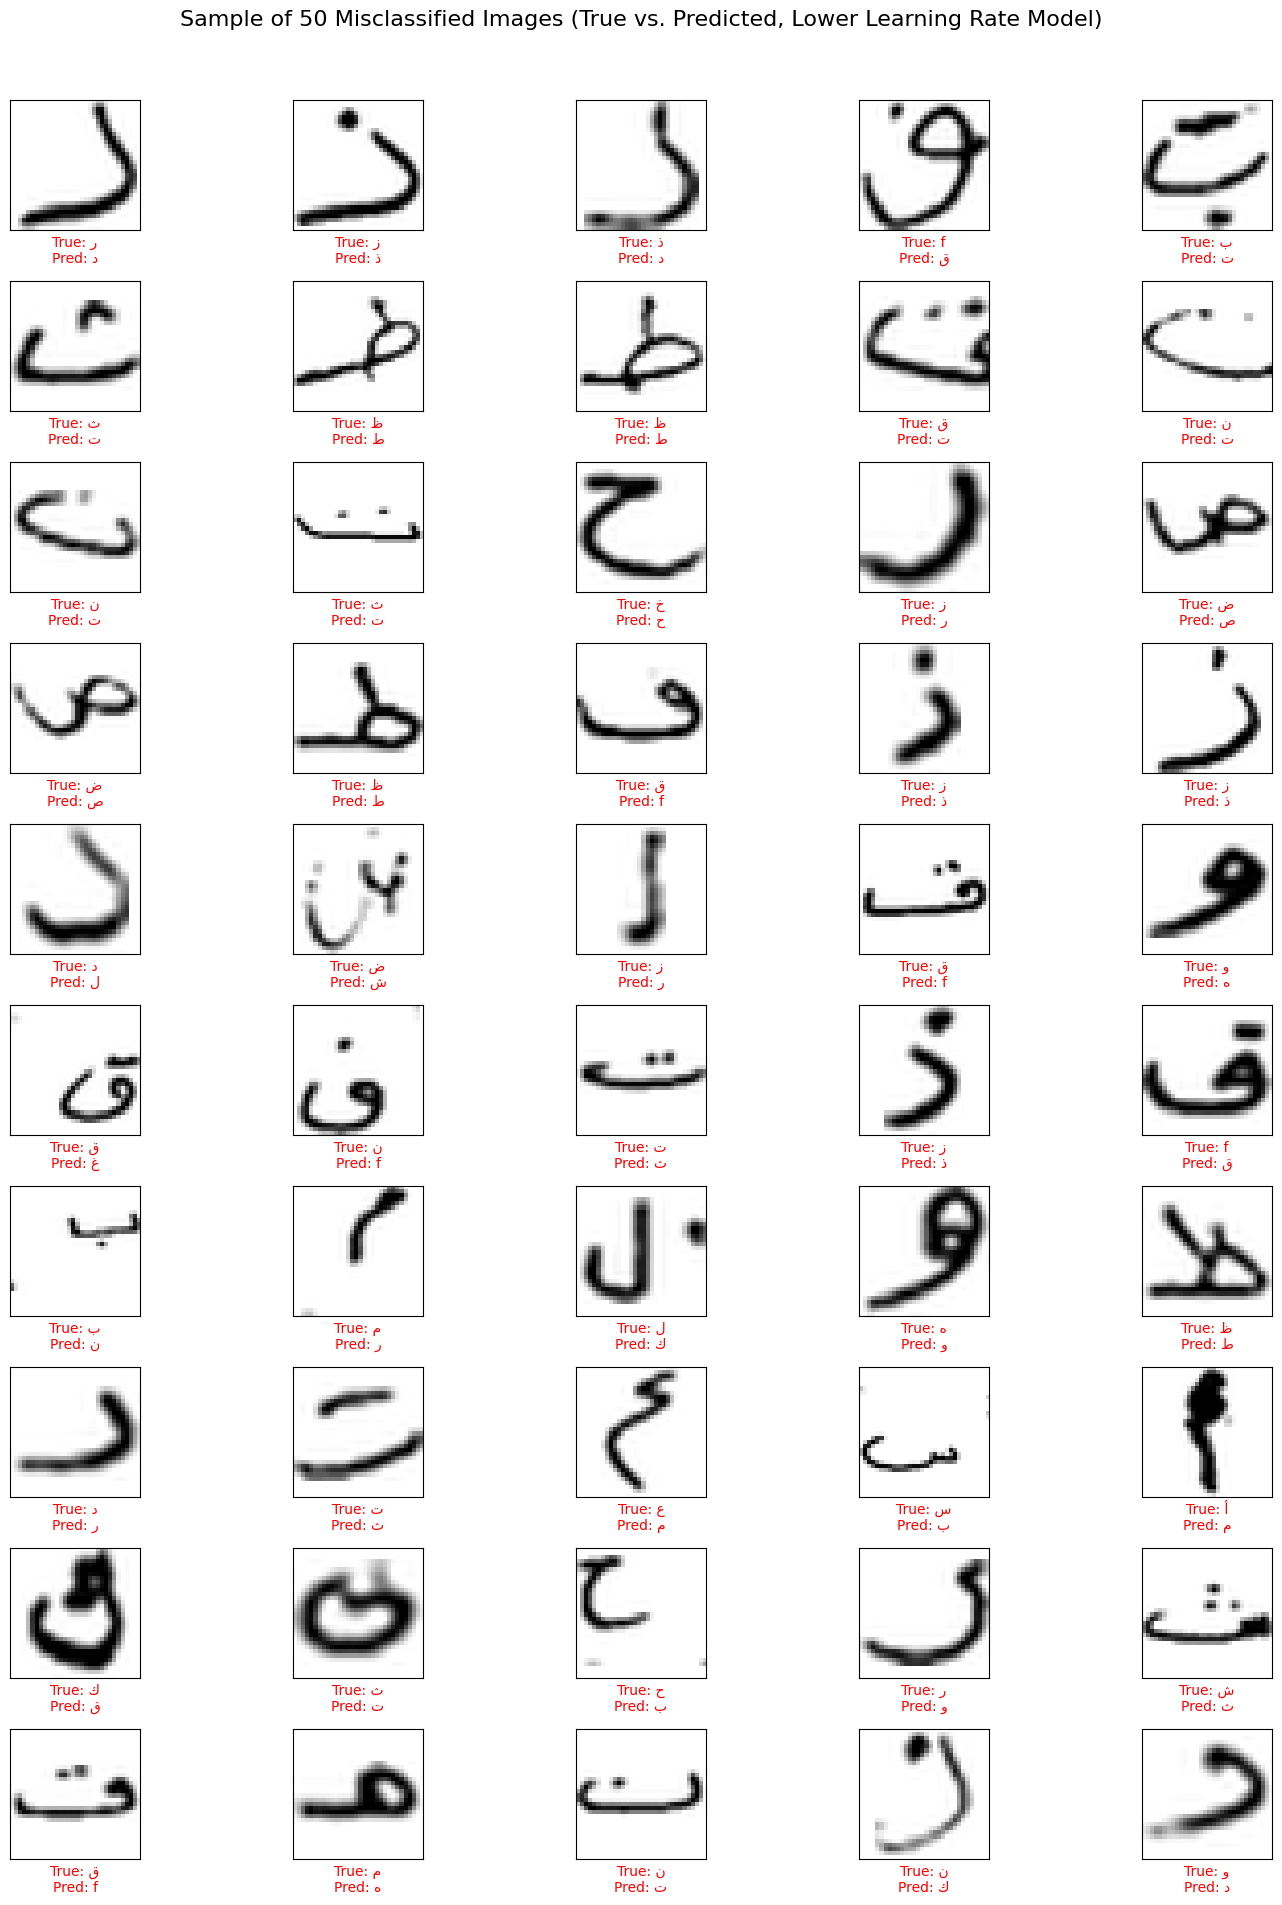

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Find indices of misclassified images using the predictions from the last trained model
misclassified_indices = np.where(y_true_classes != y_pred_classes)[0]

print(f"Total misclassified images: {len(misclassified_indices)}")

# Display all misclassified images, up to a practical limit (e.g., 50 images)
num_display = min(50, len(misclassified_indices)) # Limit to 50 for practical display

plt.figure(figsize=(15, 2 * num_display / 5 if num_display > 0 else 3))

# Use a loop over all misclassified indices or a subset if too many
for i, index in enumerate(misclassified_indices):
    if i >= num_display: # Stop after num_display images
        break
    plt.subplot(num_display // 5 + (1 if num_display % 5 > 0 else 0), 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[index], cmap=plt.cm.binary)
    true_label = arabic_letters[y_true_classes[index]]
    pred_label = arabic_letters[y_pred_classes[index]] # Use y_pred_classes from the last model
    plt.xlabel(f"True: {true_label}\nPred: {pred_label}", color='red' if true_label != pred_label else 'black')
plt.suptitle(f'Sample of {num_display} Misclassified Images (True vs. Predicted, Lower Learning Rate Model)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Task
Present a single plot showing four stages of image preprocessing for a randomly selected image from the training dataset. The stages are: the original image (`x_train_initial`), the rotated and flipped image (`x_train_rotated_flipped`), the image after component filtering (`x_train_cleaned`), and the final cropped and padded image (`x_train_padded`). Each subplot should have an appropriate title and display the true Arabic character label associated with the image.

## Select and Display Original Image

### Subtask:
Select a random image from the training dataset (x_train_initial) and display it along with its true label. This represents the raw, un-preprocessed image.


**Reasoning**:
To fulfill the subtask, I need to select a random image from `x_train_initial`, retrieve its corresponding label, convert the label to an Arabic character, and then display the image along with its true label using matplotlib.



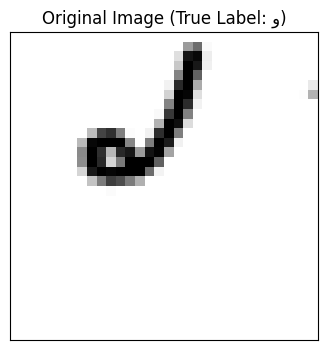

In [34]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np

# Re-define variables needed from previous cells to ensure execution context
arabic_mnist_path = '/content/drive/MyDrive/Arabic_MNIST'
train_images_df = pd.read_csv(f'{arabic_mnist_path}/csvTrainImages 13440x1024.csv')
train_labels_df = pd.read_csv(f'{arabic_mnist_path}/csvTrainLabel 13440x1.csv')
x_train_initial = train_images_df.values.reshape(-1, 32, 32, 1) / 255.0

# Define the Arabic alphabet for display (ensure it's in scope)
arabic_letters = [
    'أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'f', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي'
]

# 1. Choose a random index from the range of the training dataset `x_train_initial`.
# 2. Store this random index in a variable, for example, `random_image_index`.
random_image_index = random.randint(0, len(x_train_initial) - 1)

# 3. Retrieve the original image from `x_train_initial` at `random_image_index`.
original_image = x_train_initial[random_image_index]

# 4. Retrieve the corresponding numerical label from `train_labels_df` at `random_image_index`.
numerical_label = train_labels_df.iloc[random_image_index, 0]

# 5. Convert the numerical label to its Arabic character representation.
# The arabic_letters list is 0-indexed, and labels are 1-indexed, so subtract 1.
arabic_char_label = arabic_letters[numerical_label - 1]

# 6. Display the original image using `matplotlib.pyplot.imshow()` with a binary colormap.
plt.figure(figsize=(4, 4))
plt.imshow(original_image.squeeze(), cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.grid(False)

# 7. Add a title to the plot indicating 'Original Image' and the true Arabic character label.
plt.title(f'Original Image (True Label: {arabic_char_label})')
plt.show()

/tmp/ipython-input-229434561.py:87: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray((image_array_2d * 255).astype(np.uint8), mode='L')


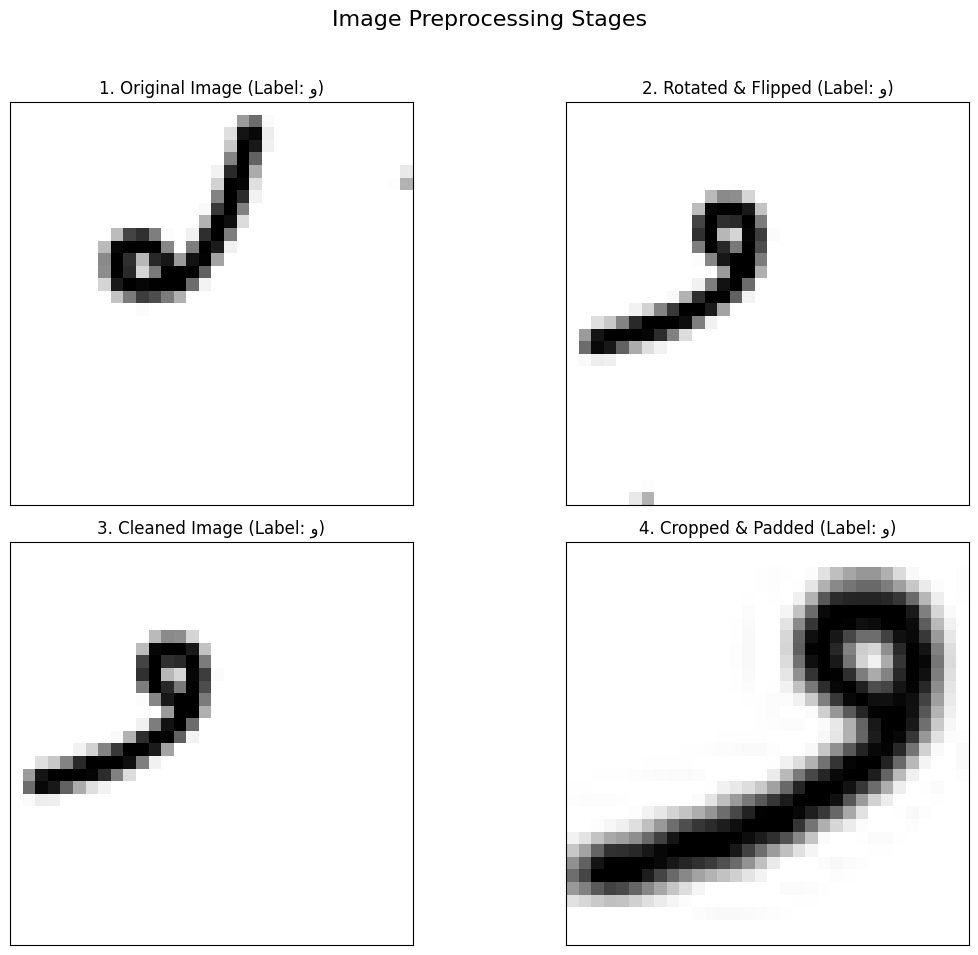

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt
from PIL import Image

# --- Re-define functions from previous preprocessing steps ---

def rotate_single_image(image_array, angle_degrees):
    # scipy.ndimage.rotate expects a 2D or 3D array, so we remove the channel dimension for rotation
    # and then add it back. The reshape=False prevents automatic resizing of the output.
    # mode='nearest' fills new pixels with the nearest value.
    # order=1 for bilinear interpolation.
    rotated_image = rotate(image_array[:, :, 0], angle_degrees, reshape=False, mode='nearest', order=1)
    return rotated_image[:, :, np.newaxis] # Add the channel dimension back

def remove_small_components(image_array, threshold_area=6, proximity_threshold=2):
    if image_array.ndim == 3 and image_array.shape[2] == 1:
        image_2d = image_array[:, :, 0]
    elif image_array.ndim == 2:
        image_2d = image_array
    else:
        raise ValueError("Expected a grayscale image (2D or 3D with 1 channel).")

    labeled_image = label(image_2d > 0.0)
    regions = regionprops(labeled_image)

    if not regions:
        return np.zeros_like(image_2d)[:, :, np.newaxis]

    largest_region = max(regions, key=lambda r: r.area)
    cleaned_image = np.zeros_like(image_2d, dtype=image_2d.dtype)
    cleaned_image[labeled_image == largest_region.label] = image_2d[labeled_image == largest_region.label]
    largest_component_mask = (labeled_image == largest_region.label)
    distance_from_largest = distance_transform_edt(~largest_component_mask)

    for region in regions:
        if region != largest_region:
            if region.area >= threshold_area:
                cleaned_image[labeled_image == region.label] = image_2d[labeled_image == region.label]
            else:
                small_component_mask = (labeled_image == region.label)
                min_dist_to_largest = np.min(distance_from_largest[small_component_mask])
                if min_dist_to_largest <= proximity_threshold:
                    cleaned_image[labeled_image == region.label] = image_2d[labeled_image == region.label]
    return cleaned_image[:, :, np.newaxis]

def crop_image_to_bbox(image_array):
    if image_array.ndim == 3 and image_array.shape[2] == 1:
        image_2d = image_array[:, :, 0]
    elif image_array.ndim == 2:
        image_2d = image_array
    else:
        raise ValueError("Expected a grayscale image (2D or 3D with 1 channel).")

    coords = np.argwhere(image_2d > 0)
    if coords.size == 0:
        return np.zeros(image_2d.shape, dtype=image_2d.dtype)

    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    cropped_image = image_2d[x_min:x_max+1, y_min:y_max+1]
    return cropped_image

def resize_image_with_padding(image_array, target_size=(32, 32), pad_value=0.0):
    image_array_2d = np.squeeze(image_array)

    if image_array_2d.ndim != 2:
        raise ValueError(f"Expected a 2D grayscale image for resizing, but got {image_array_2d.ndim} dimensions.")

    h, w = image_array_2d.shape
    target_h, target_w = target_size

    if h == 0 or w == 0:
        return np.full(target_size, pad_value, dtype=np.float32)

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)

    new_w = max(1, new_w) if w > 0 else 0
    new_h = max(1, new_h) if h > 0 else 0

    if new_w == 0 or new_h == 0:
        return np.full(target_size, pad_value, dtype=np.float32)

    img = Image.fromarray((image_array_2d * 255).astype(np.uint8), mode='L')
    resized_img = img.resize((new_w, new_h), Image.LANCZOS)
    resized_img_array = np.array(resized_img) / 255.0

    padded_img = np.full(target_size, pad_value, dtype=np.float32)
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    padded_img[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_img_array
    return padded_img

# --- Re-apply preprocessing to generate missing variables ---

# Rotation and Flipping
rotation_angle_degrees = 90 # As used in original cell dc4b3d75
x_train_rotated_flipped_single = rotate_single_image(x_train_initial[random_image_index], rotation_angle_degrees)
x_train_rotated_flipped_single = x_train_rotated_flipped_single[::-1, :, :]

# Noise Removal (Cleaning)
x_train_cleaned_single = remove_small_components(x_train_rotated_flipped_single)

# Cropping and Padding
x_train_padded_single = resize_image_with_padding(crop_image_to_bbox(x_train_cleaned_single))
x_train_padded_single = x_train_padded_single.reshape(32, 32, 1) # Add channel dimension back

# --- Plotting the four stages ---
plt.figure(figsize=(12, 10))

# Plot 1: Original Image
plt.subplot(2, 2, 1)
plt.imshow(x_train_initial[random_image_index].squeeze(), cmap=plt.cm.binary)
plt.title(f'1. Original Image (Label: {arabic_char_label})')
plt.xticks([])
plt.yticks([])
plt.grid(False)

# Plot 2: Rotated and Flipped Image
plt.subplot(2, 2, 2)
plt.imshow(x_train_rotated_flipped_single.squeeze(), cmap=plt.cm.binary)
plt.title(f'2. Rotated & Flipped (Label: {arabic_char_label})')
plt.xticks([])
plt.yticks([])
plt.grid(False)

# Plot 3: Cleaned Image (after noise removal)
plt.subplot(2, 2, 3)
plt.imshow(x_train_cleaned_single.squeeze(), cmap=plt.cm.binary)
plt.title(f'3. Cleaned Image (Label: {arabic_char_label})')
plt.xticks([])
plt.yticks([])
plt.grid(False)

# Plot 4: Cropped and Padded Image
plt.subplot(2, 2, 4)
plt.imshow(x_train_padded_single.squeeze(), cmap=plt.cm.binary)
plt.title(f'4. Cropped & Padded (Label: {arabic_char_label})')
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.suptitle('Image Preprocessing Stages', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()